In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mopet import mopet
from scipy.signal import find_peaks

from synchronization import plots
from synchronization import runner
from synchronization import constants
from synchronization import processing

# ING Network

In this notebook we model two interconnected inhibitory networks. Gamma rhythm is created by ING mechanism.

We explore the effect on noise strength and try to replicate Meng & Rieckes result.

Based on our findings for the ING model, we move forward to the PING model.

**ING network**
* 1000 Neurons in each Network
* Low Recurrent inhibition


In [2]:
params = {
    "runtime": 500.0,
    
    "ou_enabled": [False, False],
    
    "model_EI": False,
    
    "poisson_enabled": [True, True],
    "poisson_variance": 0.5,
    "poisson_p": 0.75,
    "poisson_size": 800,
    "poisson_mean_input": 300,
    "poisson_I_enabled": True,
    "poisson_I_ratio": 1.0,
    
    "N_pop": 2,
    "net_record_spikes": 200,    
    
    # Only Synaptic Strengths for I<->I.
    "J_ppee": 0.0,
    "J_ppei": 0.0,
    "J_ppii": 0.15,
    
    "J_itoi": 0.4,
    "J_etoe": 0.0,
    "J_etoi": 0.0,
    "J_itoe": 0.0,
    
    # Only connectivity for I to I, all-to-all.
    "p_ppee": 0.00,
    "p_ppei": 0.00,
    "p_ppii": 1.0,
    "p_etoi": 0.0,
    "p_etoe": 0,
    "p_itoe": 0.0,
    "p_itoi": 1.0,
    
    "syn_net_inh": True,
    "syn_net_exc": False,
    
    # Time Constants
    "tau_GABA": 20.0,
    
    "const_delay": 0.0,
    
    "N_e": 1,
    "N_i": 1000,
}

## ING Network with weak coupling and weak noise

We expect to see then almost no overlap in the area around the dominant frequency.

In [4]:
params_mid = dict(params)
params_mid.update({
    "runtime": 1000,
    "poisson_variance": 0.9,
    "poisson_p": 0.84,
    "net_record_spikes": 1000,

    # MODIFIED
    # reduce inter-network coupling to get clear separation between the networks.
    "J_ppii": 0.00,
    # reduce time decay of GABA
    "tau_GABA": 30.0,
    
    # Lower inhibition -> Faster Network
    "J_itoi": 0.5,
    
    "poisson_mean_input": 300,
})

# GABA Decay Values < 40 can still considered be realsitic? (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2666407/)

"""
1. Want to reduce the frequency (not amplitude) and keep a strong ING rhythm
* play around with tau_GABA
* reduce mean noise input
* reduce or increase inhibition?
* Any other time constants?
* Reduce influence between networks? I already see overlap in their frequency bands..

2. Have to analyze if I can keep peak frequency the same with increasing noise strength. Atm peak frequency increases as well, goes up to 80

"""

'\n1. Want to reduce the frequency (not amplitude) and keep a strong ING rhythm\n* play around with tau_GABA\n* reduce mean noise input\n* reduce or increase inhibition?\n* Any other time constants?\n* Reduce influence between networks? I already see overlap in their frequency bands..\n\n2. Have to analyze if I can keep peak frequency the same with increasing noise strength. Atm peak frequency increases as well, goes up to 80\n\n'

In [5]:
model = runner.run(
    modified_params=params_mid,
    file_name="ING_1",
    load=True
)

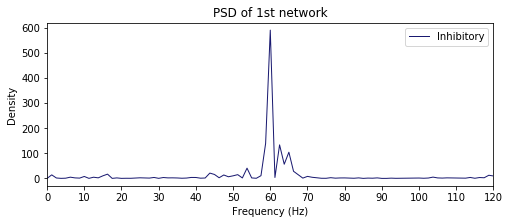

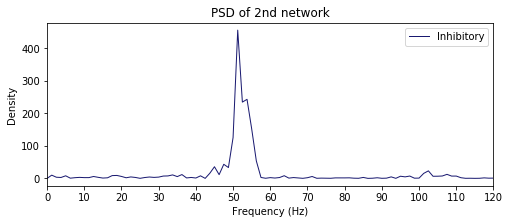

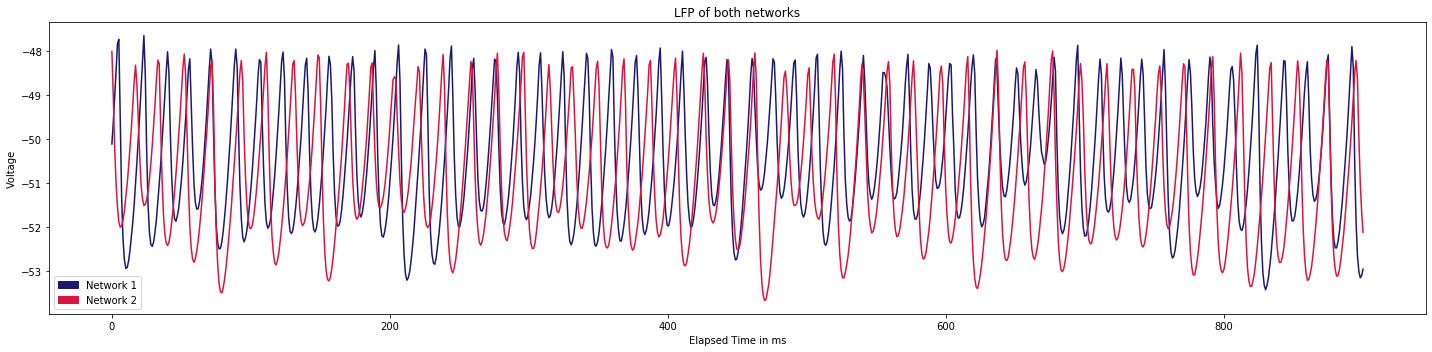

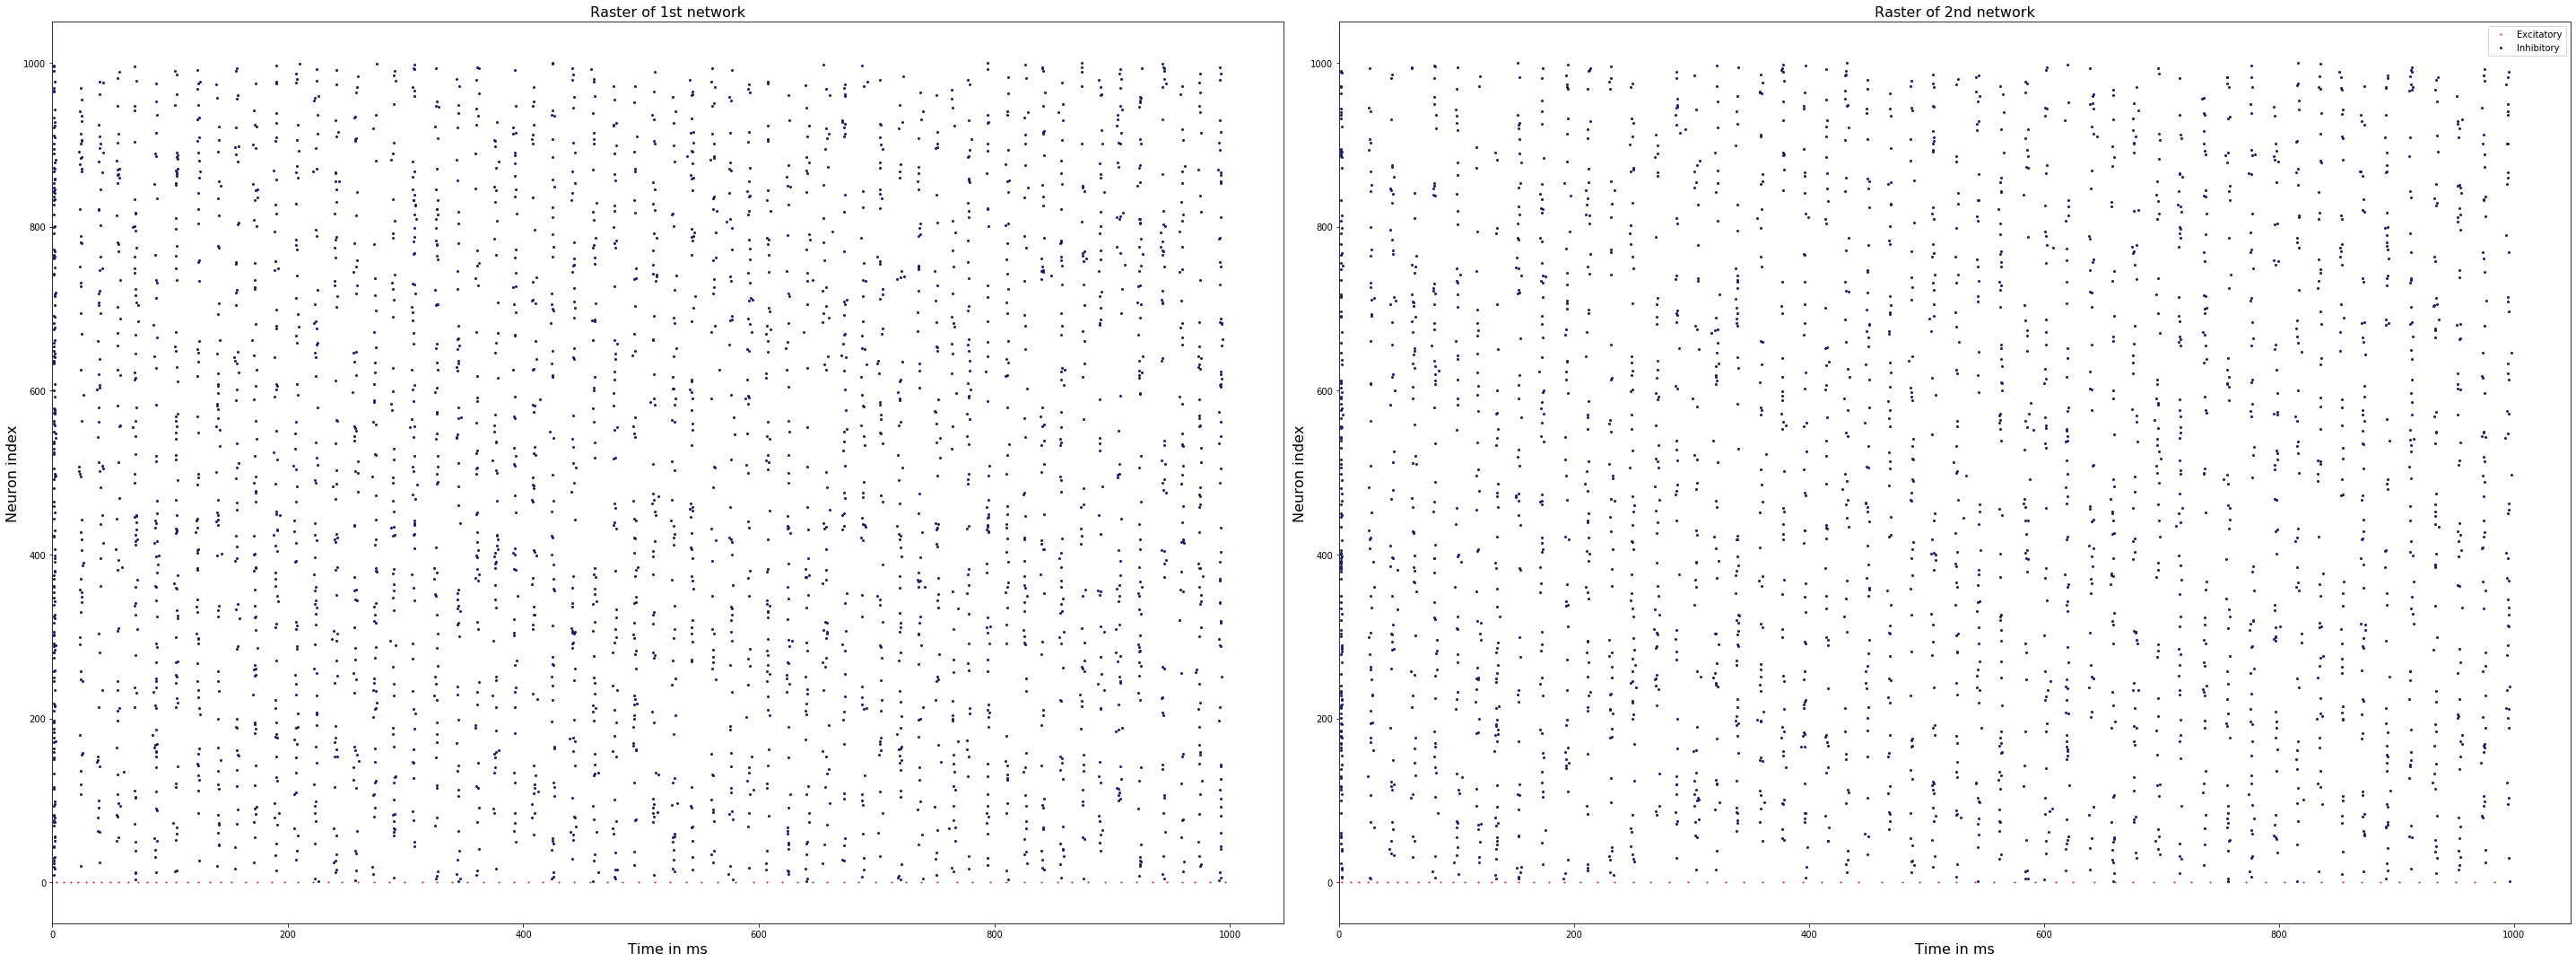

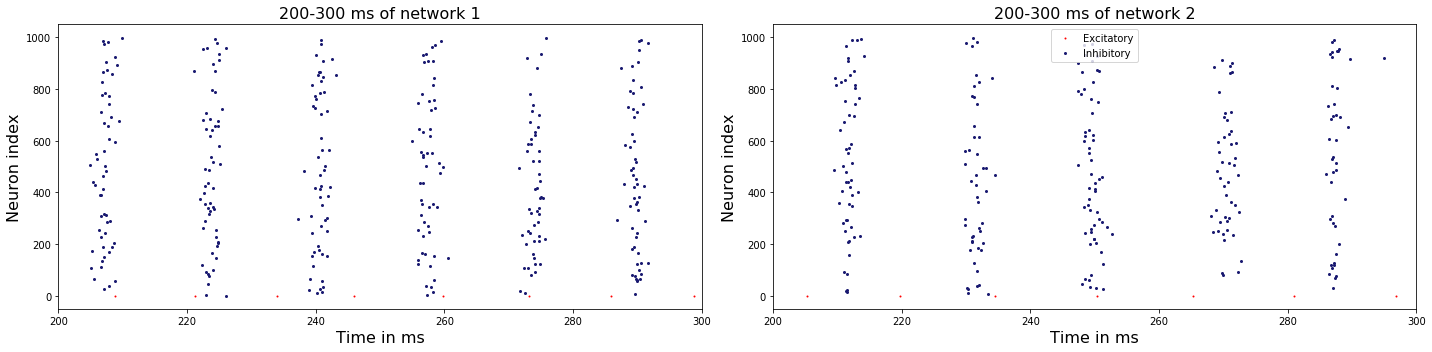

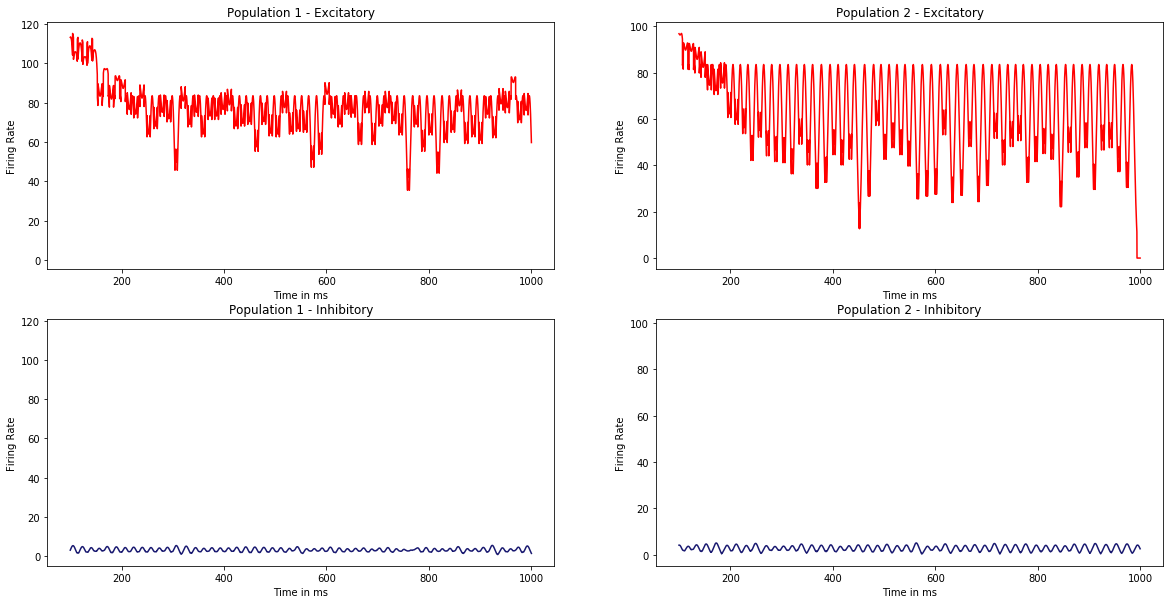

In [49]:
plots.plot_results(model, full_raster=True, psd_group="INH")

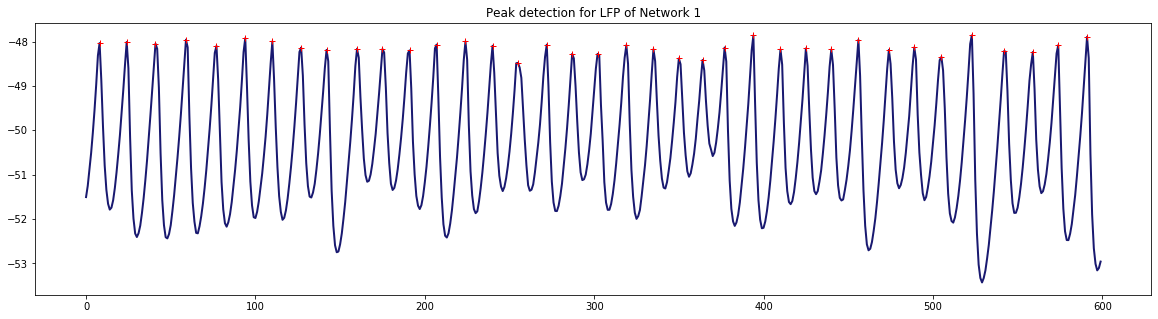

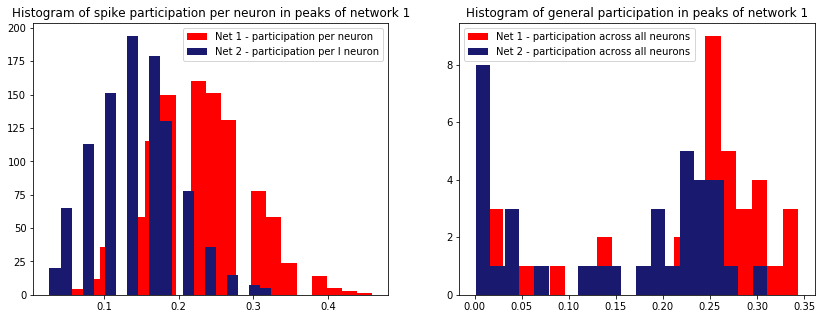

In [6]:
plots.spike_participation_histograms(model)

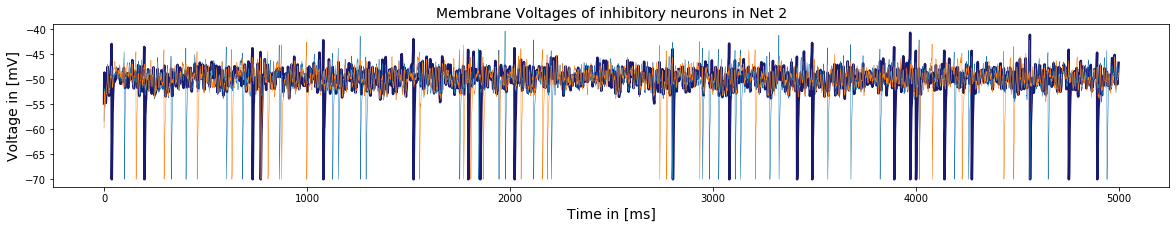

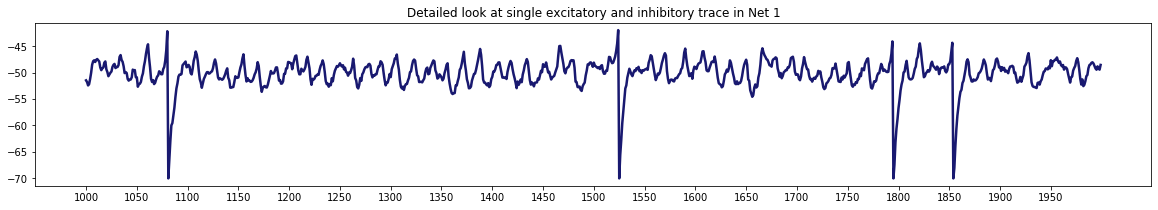

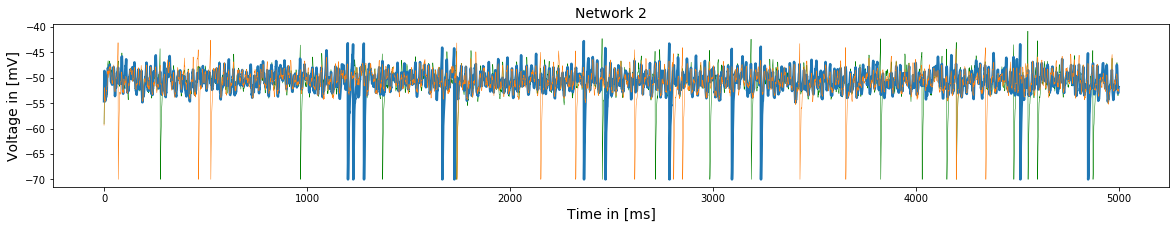

In [20]:
plots.membrane_potentials_sample(model, detail_window=(1000, 2000))

49
951


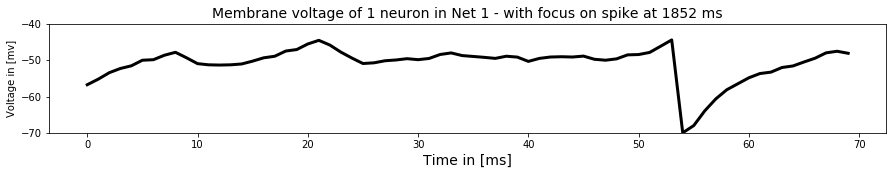

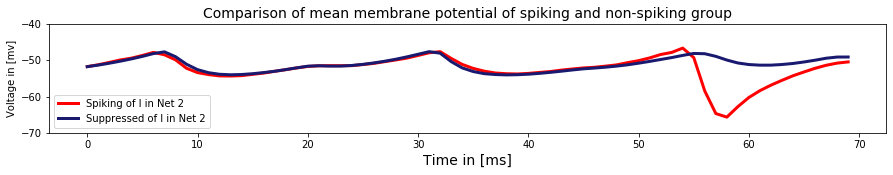

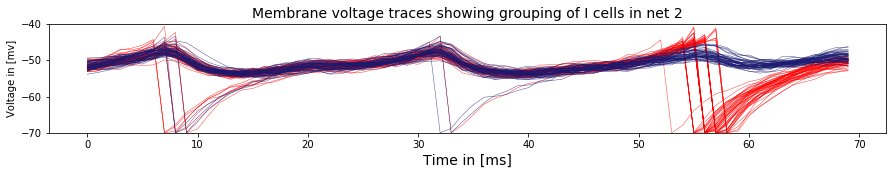

In [22]:
w = (1800, 1870)

v = model["v_all_neurons_i1"]
v2 = model["v_all_neurons_i2"]

plots.spike_variability_analysis(v, v2, window=w, t_s=1852, t_width=(6, 6))

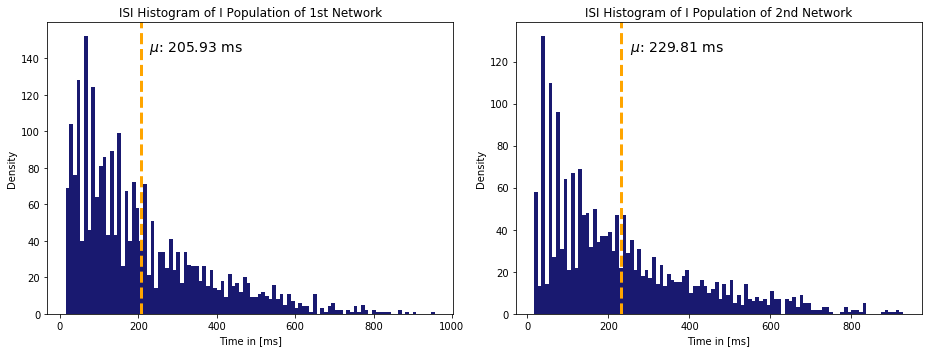

In [7]:
plots.isi_histograms(model, bins=100, filter_outlier=False)

## Synchronizing both networks by increasing network coupling

Increased network coupling will synchronize both networks.

### Small Increase in network coupling -> we see first effects

Starting simulation at t=0. s for a duration of 5. s
1.1981 s (23%) simulated in 10s, estimated 32s remaining.
2.4037 s (48%) simulated in 20s, estimated 22s remaining.
3.61505 s (72%) simulated in 30s, estimated 11s remaining.
4.8141 s (96%) simulated in 40s, estimated 2s remaining.
5. s (100%) simulated in 41s
Global Order Parameter value of: 0.8124281593037614
Mean Phase Coherence 0.4614122361569504
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.8421500194042238
Within Synchronization of Network 2 0.8642825761536739


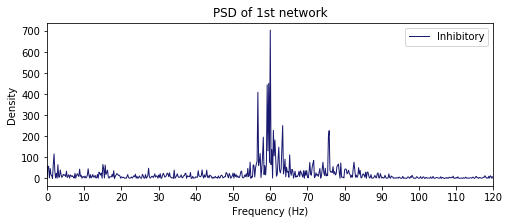

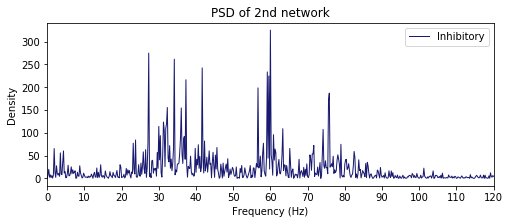

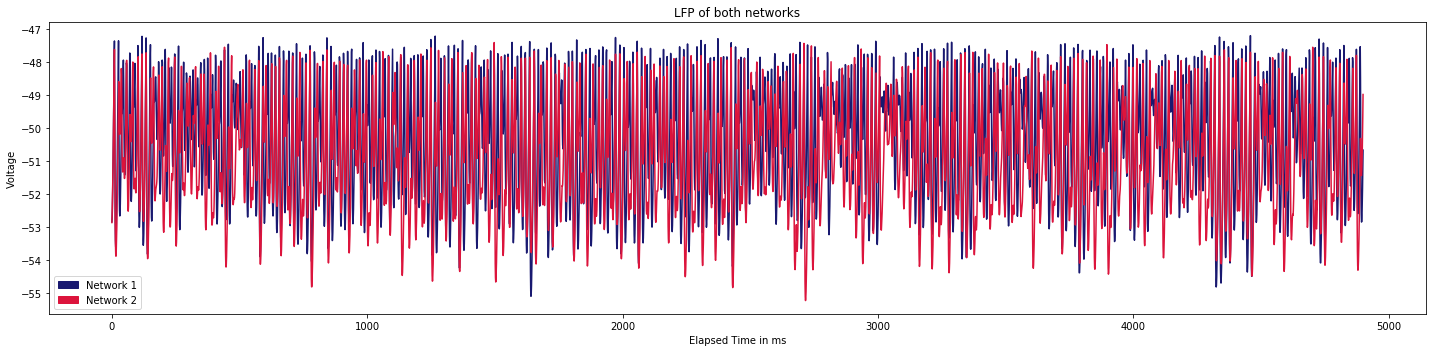

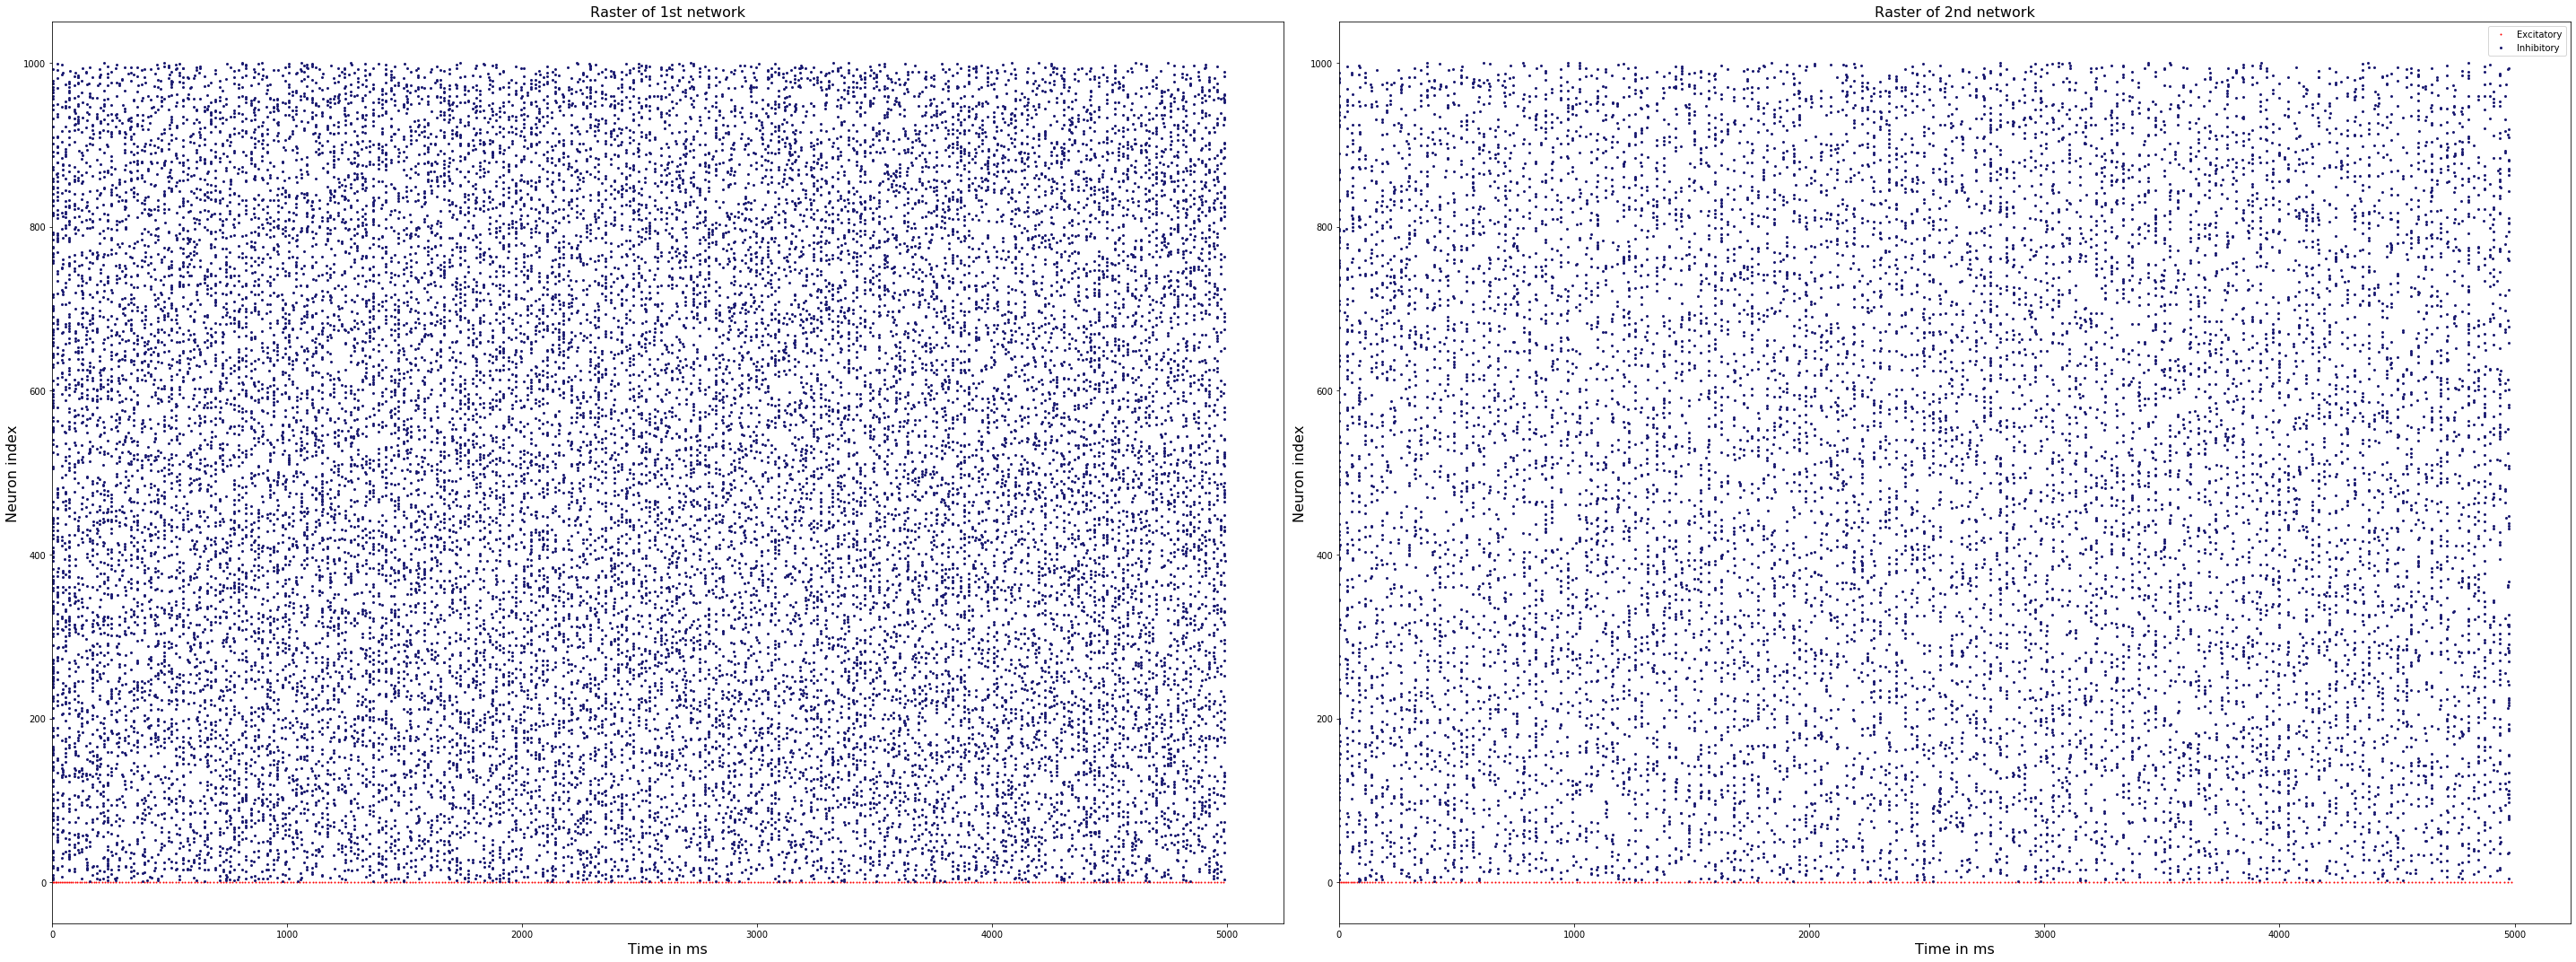

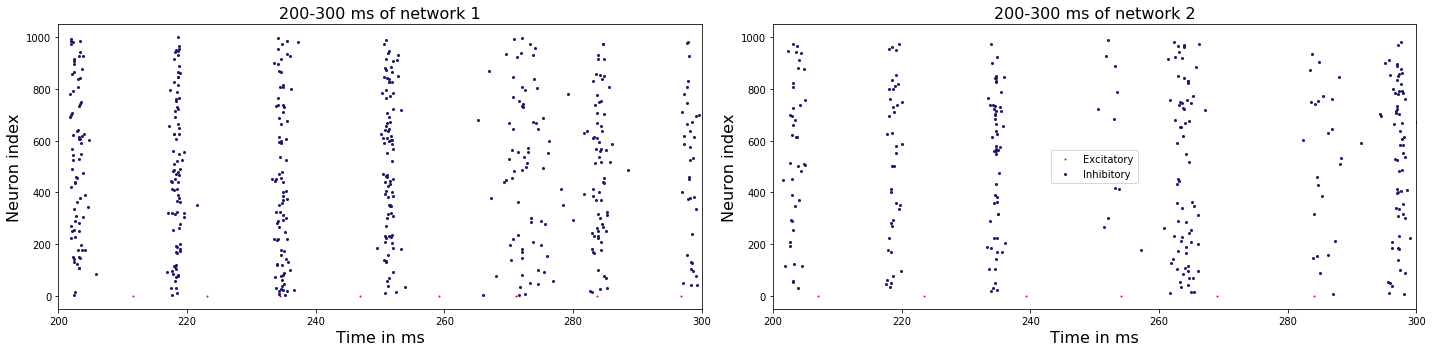

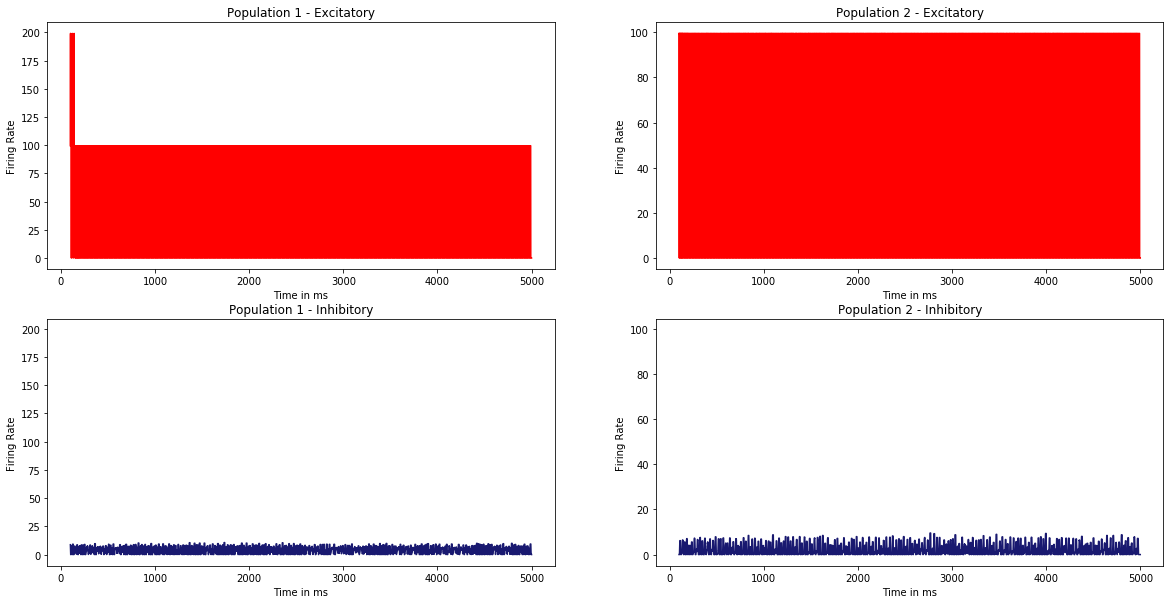

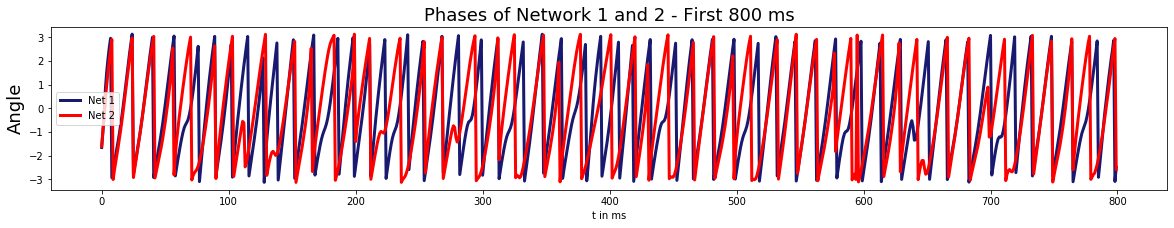

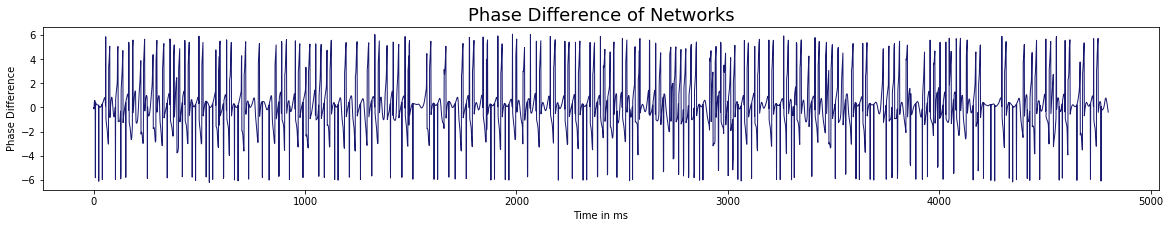

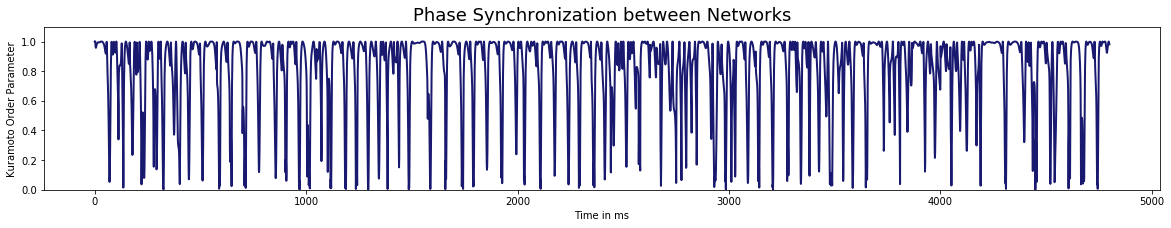

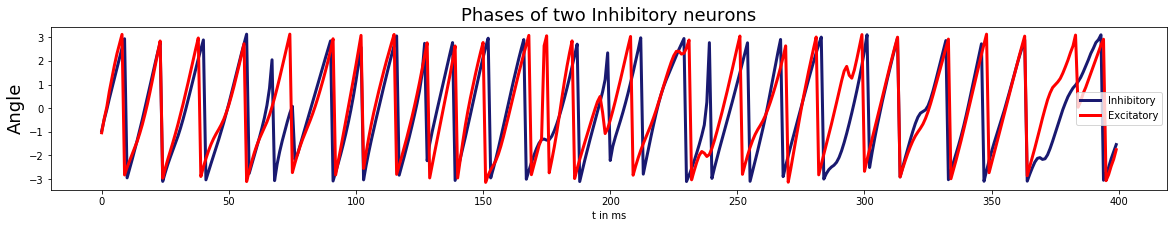

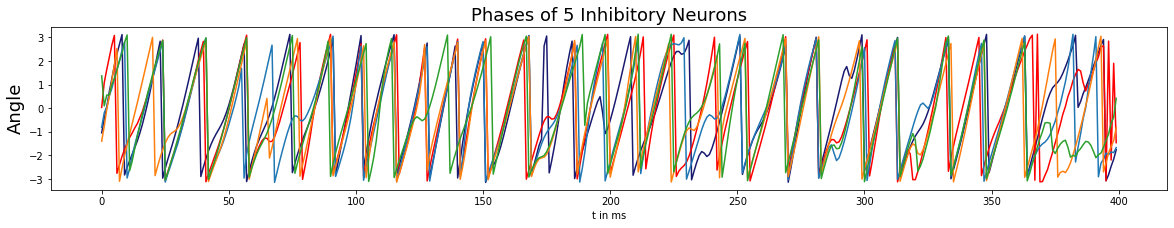

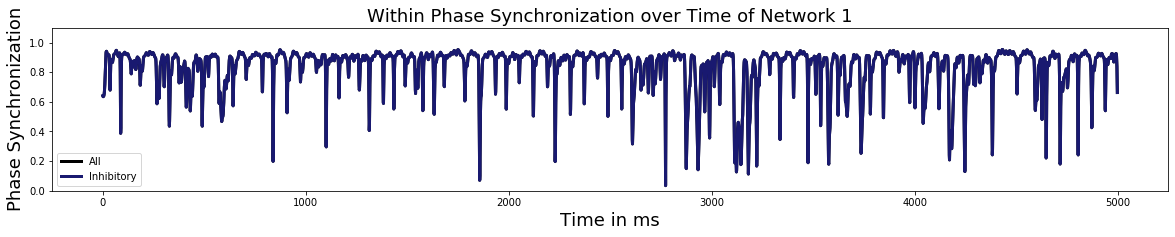

In [119]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "J_ppii": 0.2,
    "poisson_variance": 0.8,
    "poisson_p": 0.84,
    "net_record_spikes": 1000,    
})
model = runner.run(
    modified_params=synch
)

plots.plot_results(model, full_raster=True, psd_group="INH")

### Further increase in network coupling leads to 1:1 entrainment

In [130]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "J_ppii": 0.3,
    "poisson_variance": 0.8,
    "poisson_p": 0.84,
    "net_record_spikes": 1000,     
})
model = runner.run(
    modified_params=synch
)

Starting simulation at t=0. s for a duration of 5. s
1.2165 s (24%) simulated in 10s, estimated 31s remaining.
2.472 s (49%) simulated in 20s, estimated 20s remaining.
3.7695 s (75%) simulated in 30s, estimated 10s remaining.
5. s (100%) simulated in 39s


Global Order Parameter value of: 0.989401171523696
Mean Phase Coherence 0.9966872191066859
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.9145424023516735
Within Synchronization of Network 2 0.9609549379390139


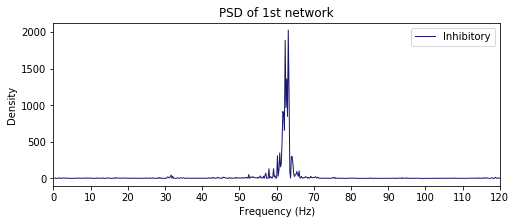

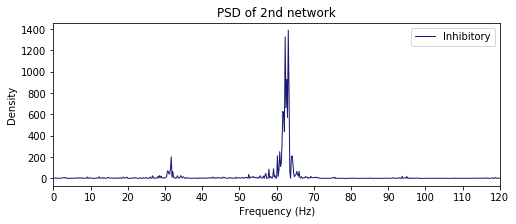

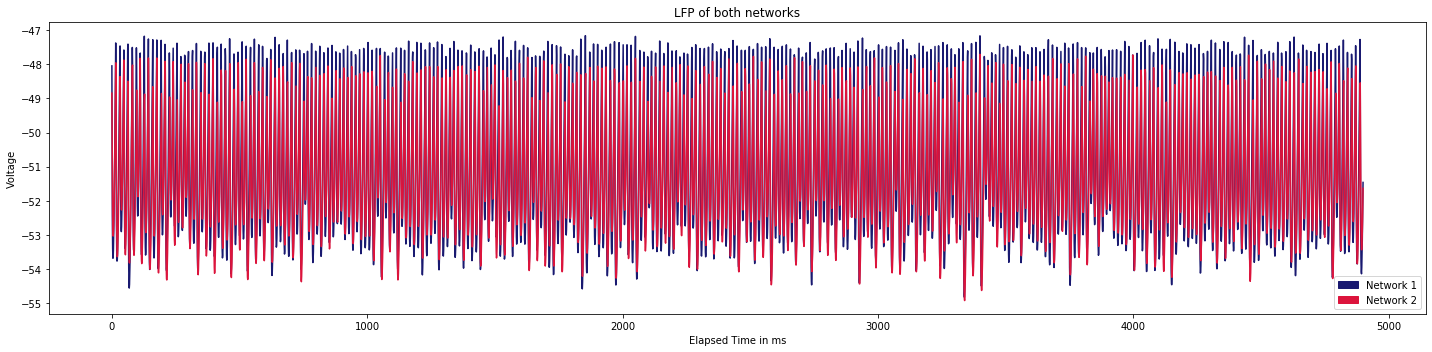

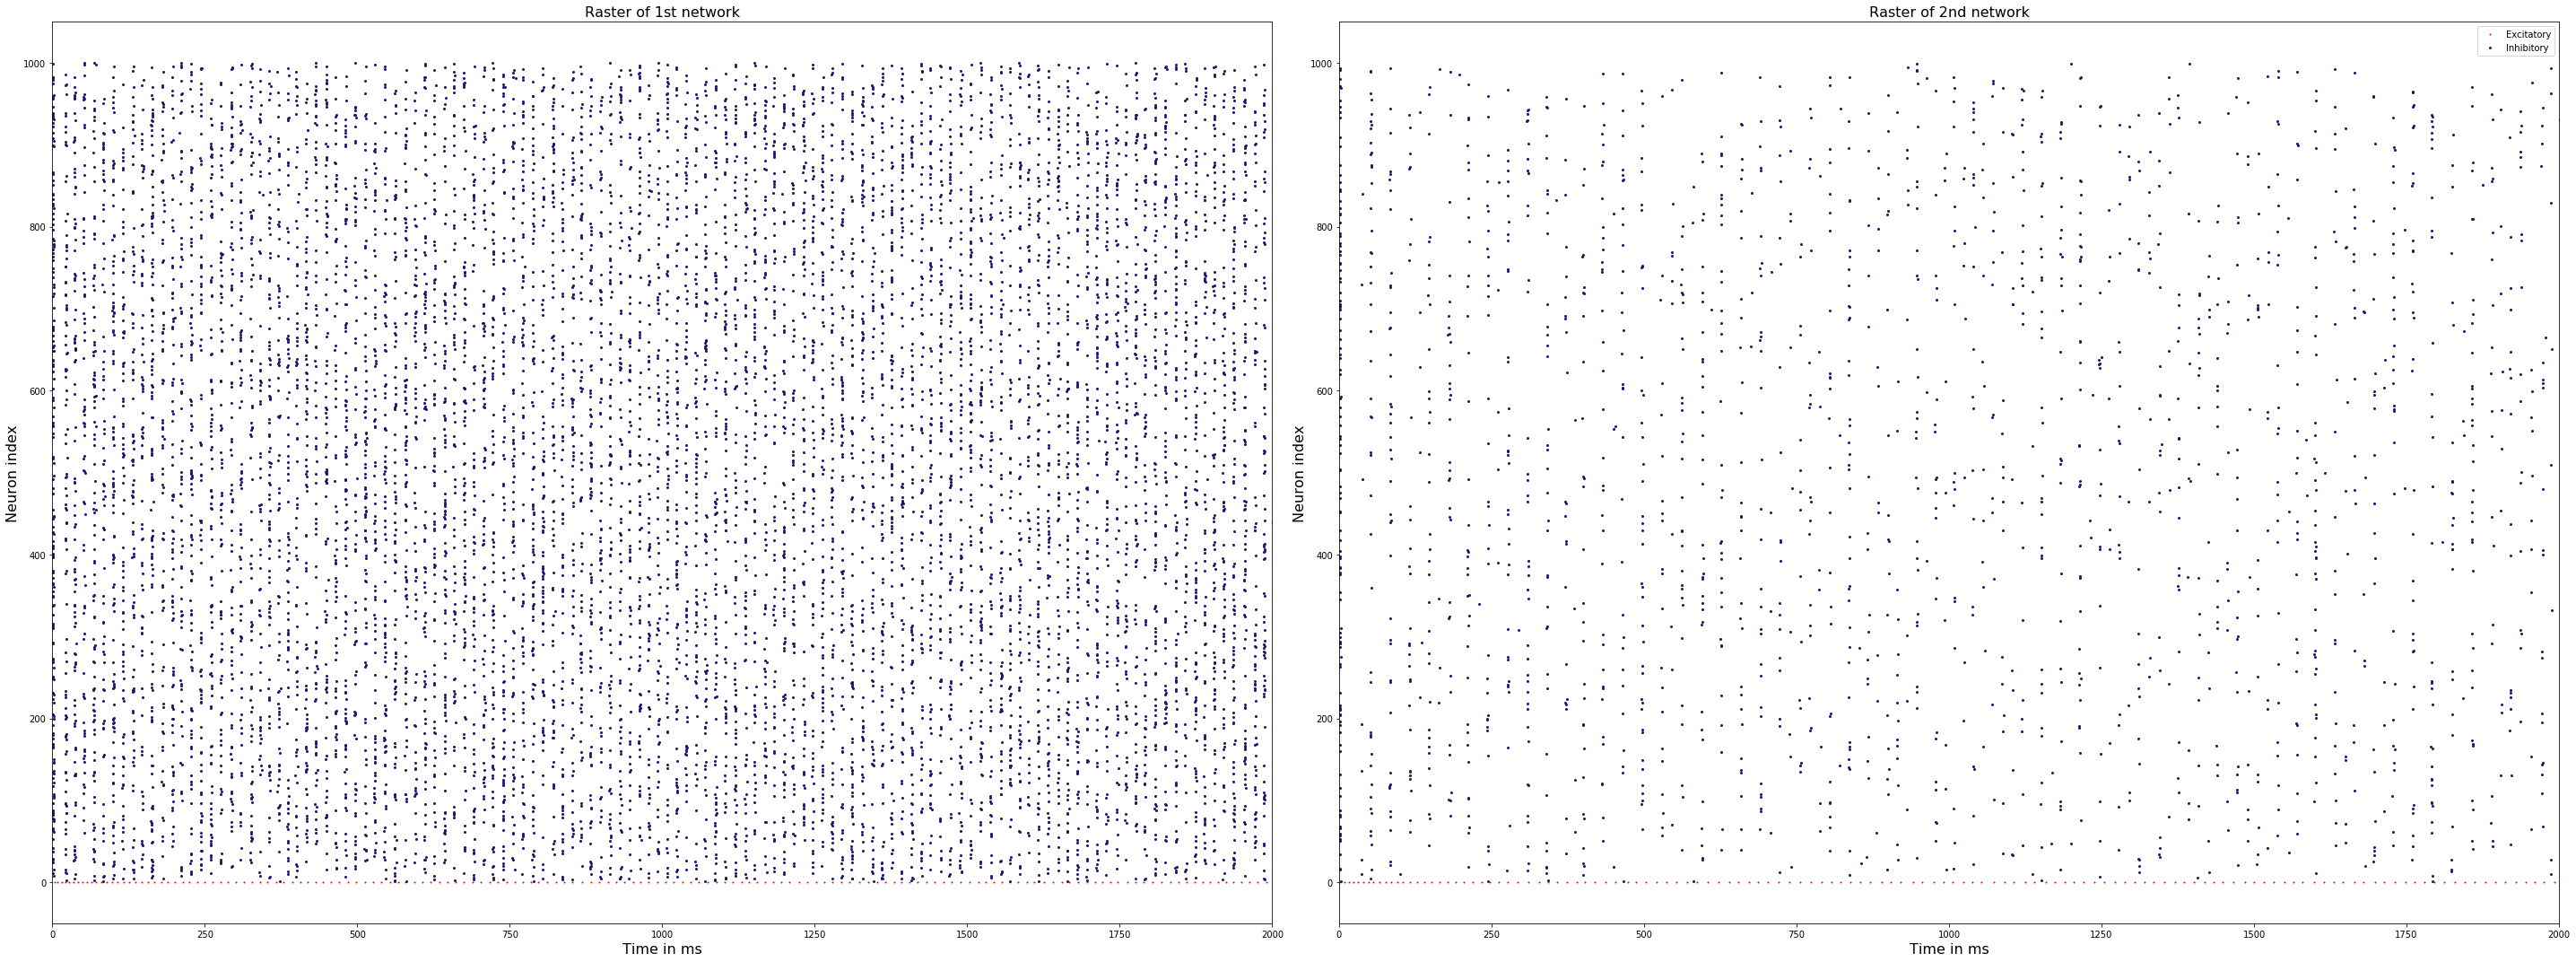

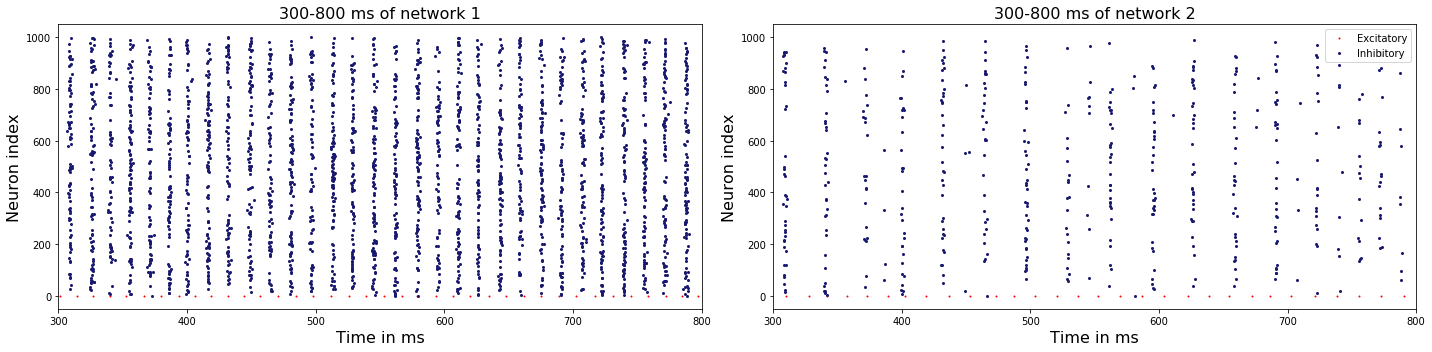

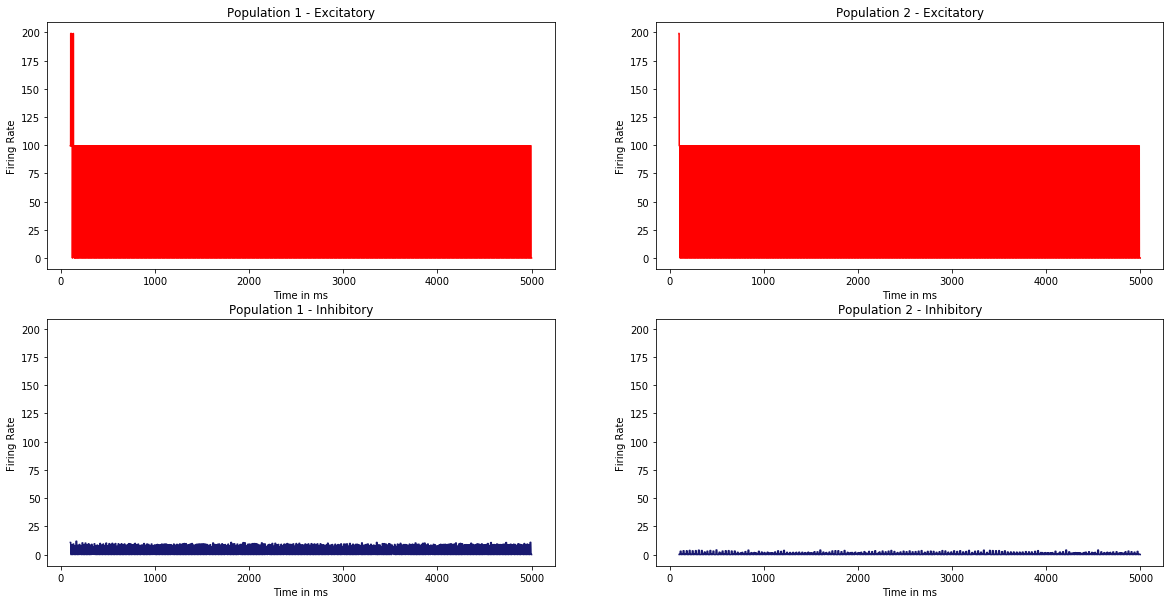

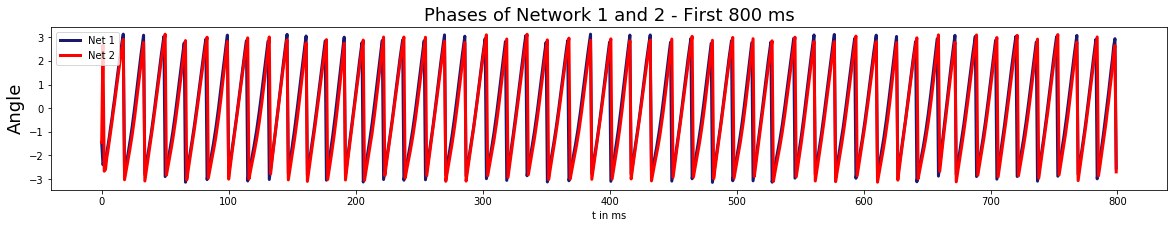

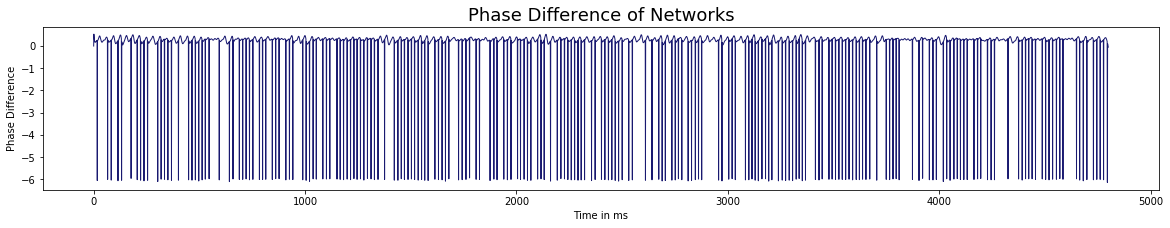

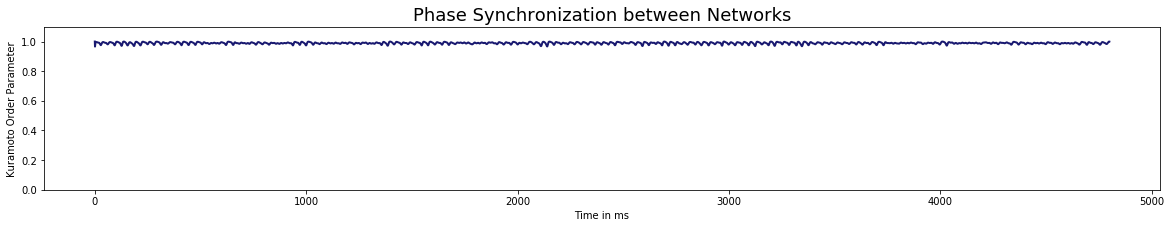

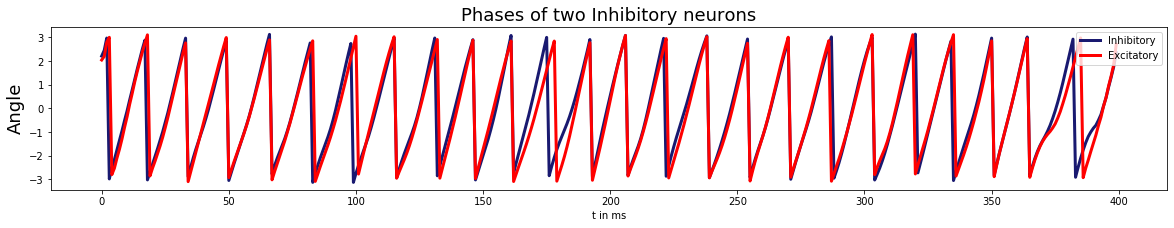

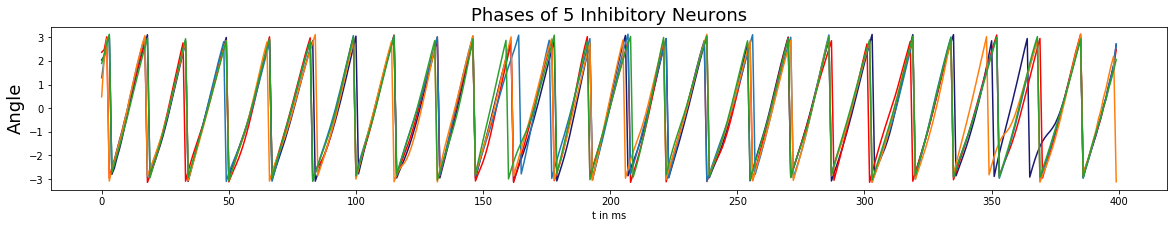

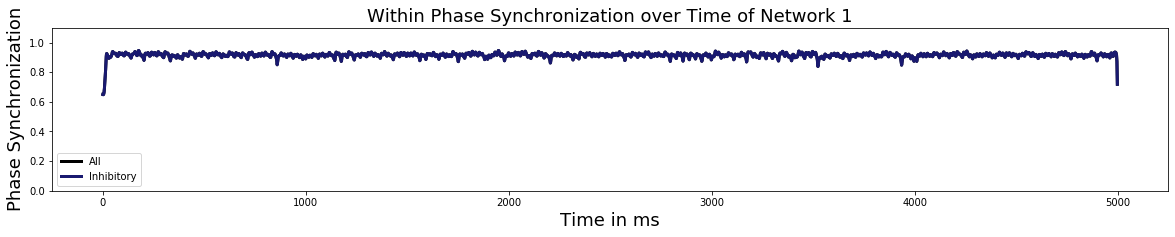

In [131]:
plots.plot_results(model, full_raster=True, psd_group="INH", excerpt_x_left=300, excerpt_x_right=800, raster_right=2000)

## Synchronizing both networks by increasing noise strength

### Increased Noise, but no synchronization yet ...

Starting simulation at t=0. s for a duration of 5. s
1.16705 s (23%) simulated in 10s, estimated 33s remaining.
2.35115 s (47%) simulated in 20s, estimated 23s remaining.
3.43085 s (68%) simulated in 30s, estimated 14s remaining.
4.636 s (92%) simulated in 40s, estimated 3s remaining.
5. s (100%) simulated in 42s
Global Order Parameter value of: 0.7061053091943379
Mean Phase Coherence 0.19354123426101102
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.773014879195512
Within Synchronization of Network 2 0.8165792655417622


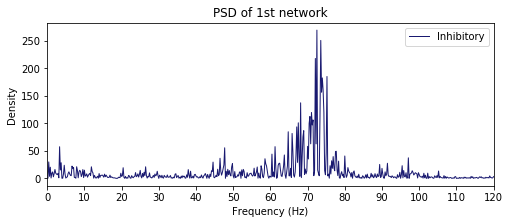

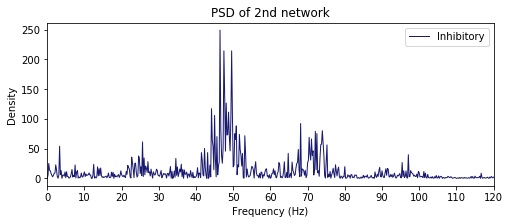

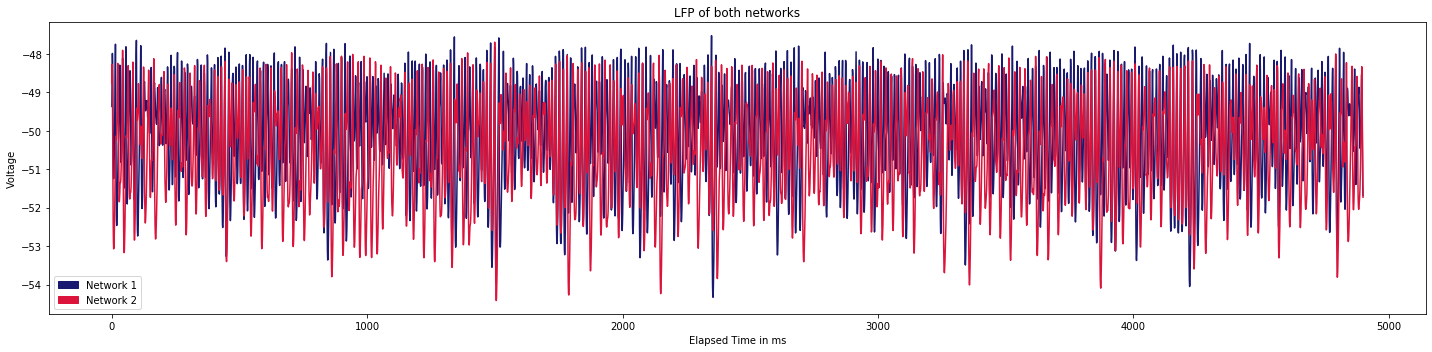

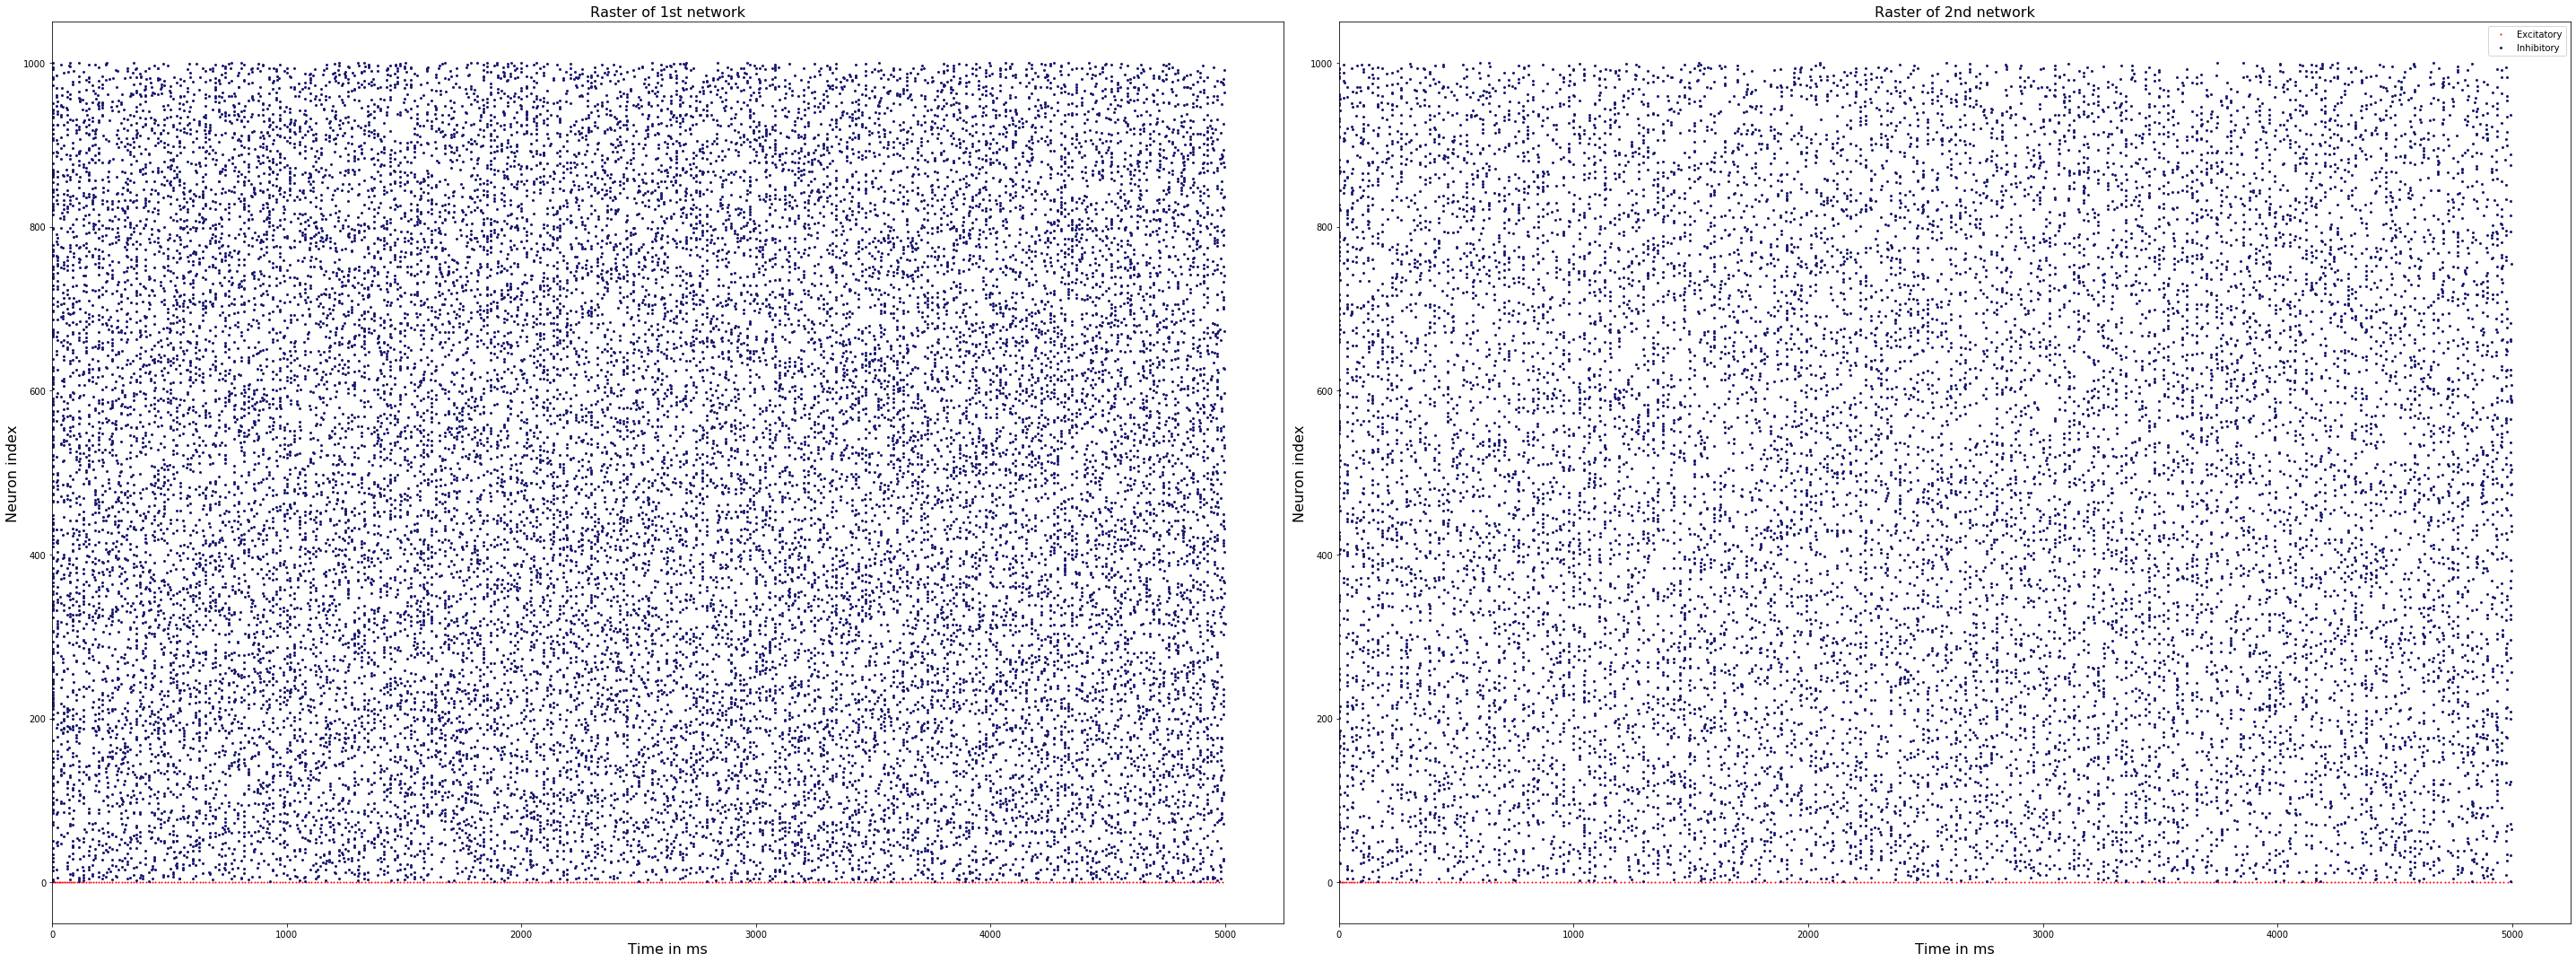

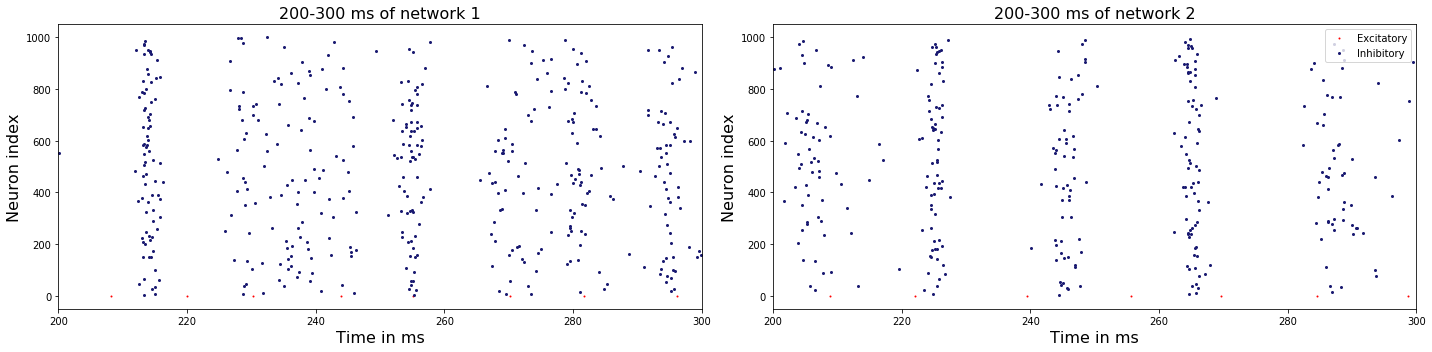

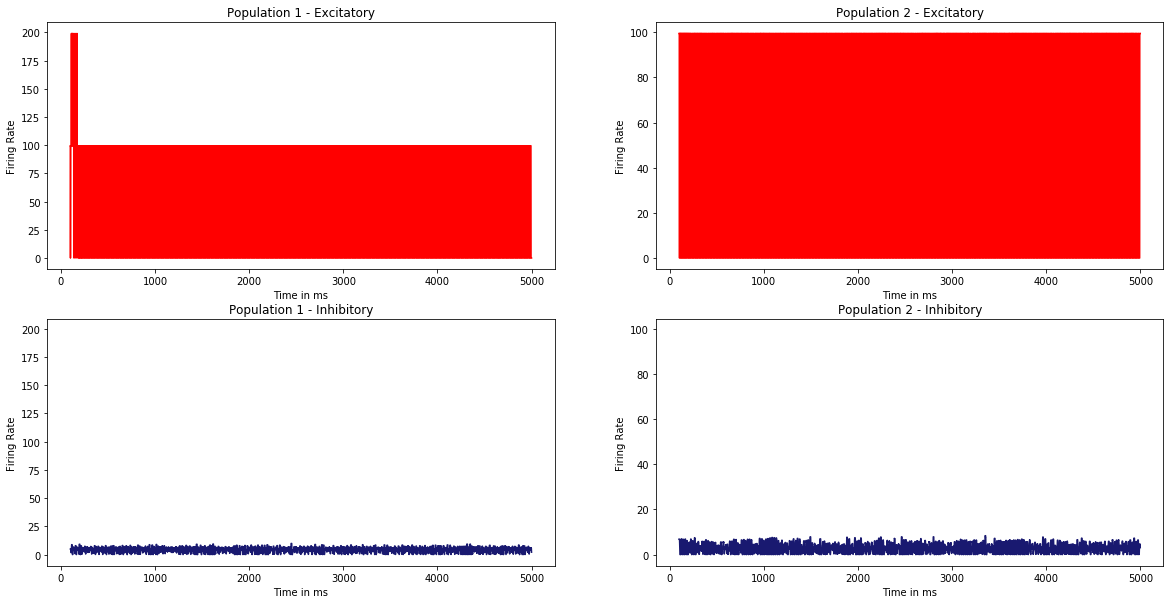

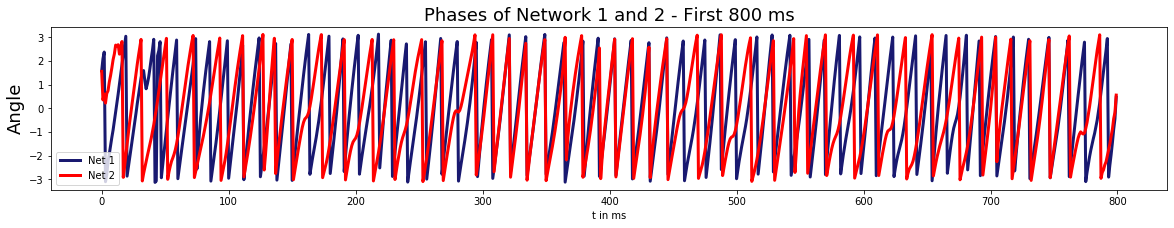

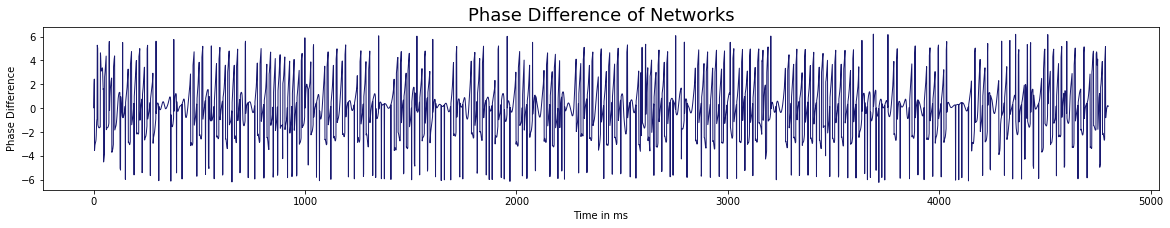

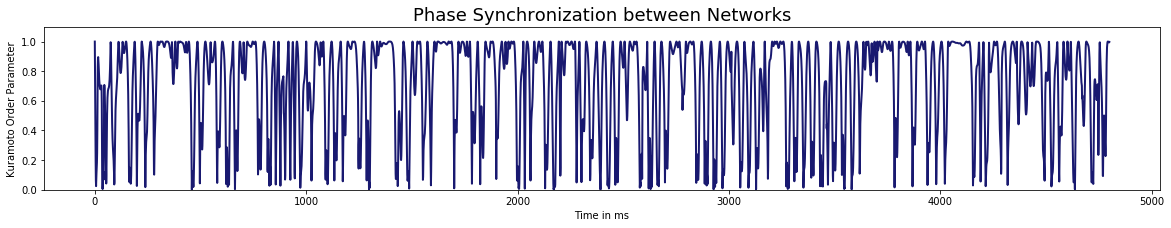

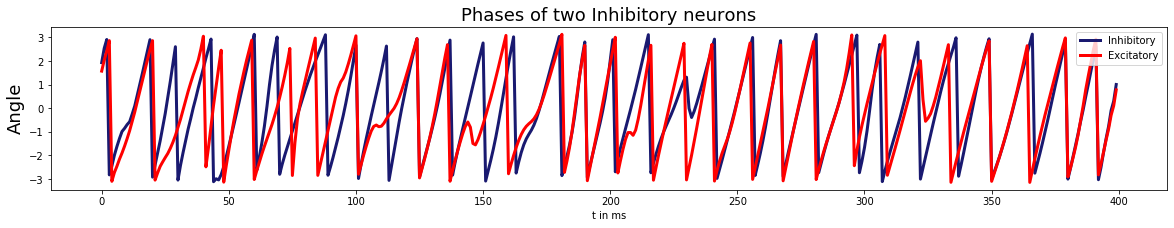

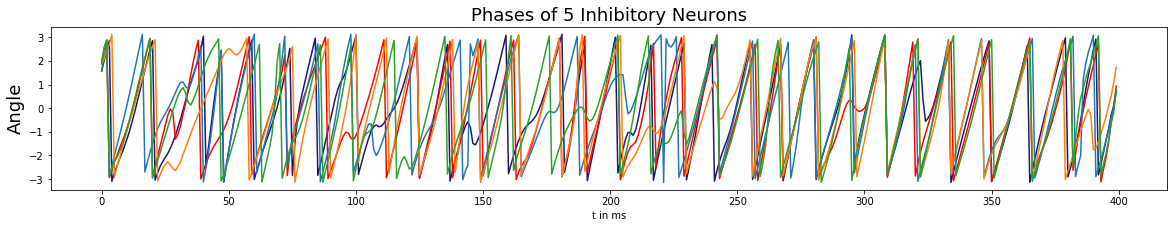

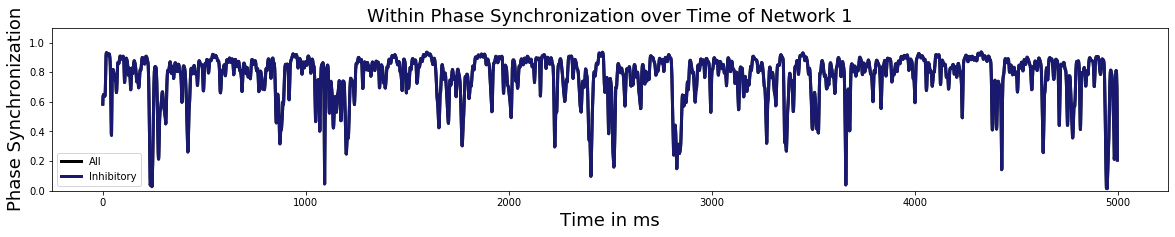

In [123]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "poisson_variance": 1.0,
    "poisson_p": 0.84,
    "net_record_spikes": 1000,  
})

model = runner.run(
    modified_params=synch
)

plots.plot_results(model, full_raster=True, psd_group="INH")

### Increase in noise leads to synchronization!

In [30]:
synch = dict(params)
synch.update({
    "runtime": 5000,
    "poisson_variance": 1.5,
    "poisson_p": 0.84,
    "net_record_spikes": 1000,  
})

model = runner.run(
    modified_params=synch,
    file_name="ING-noise-synch",
    load=True
)

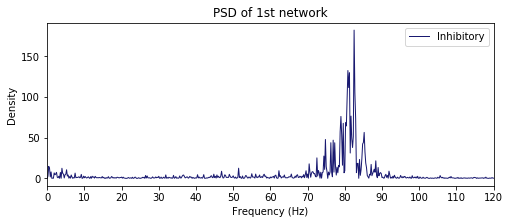

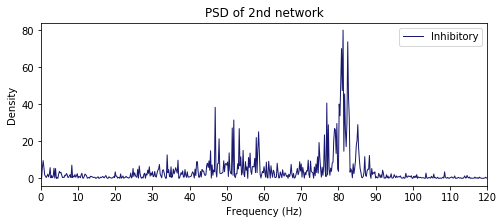

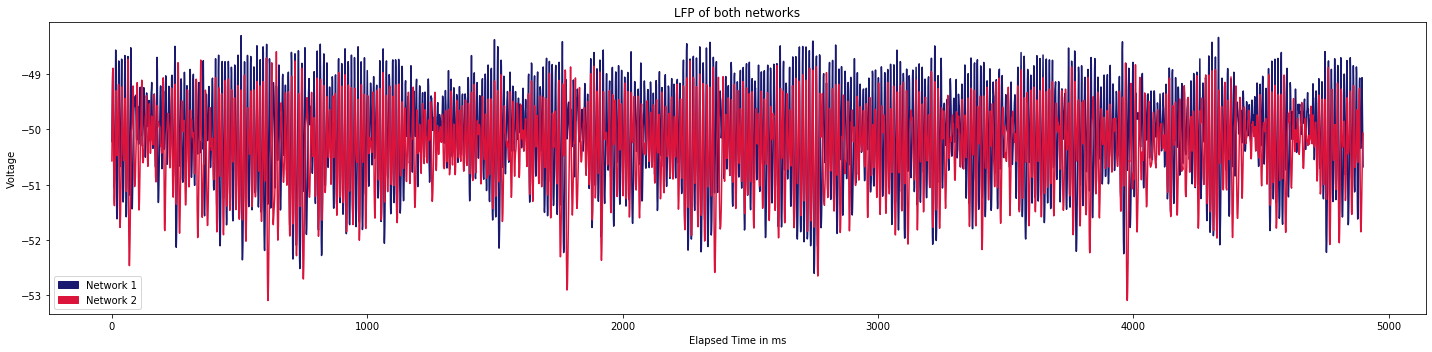

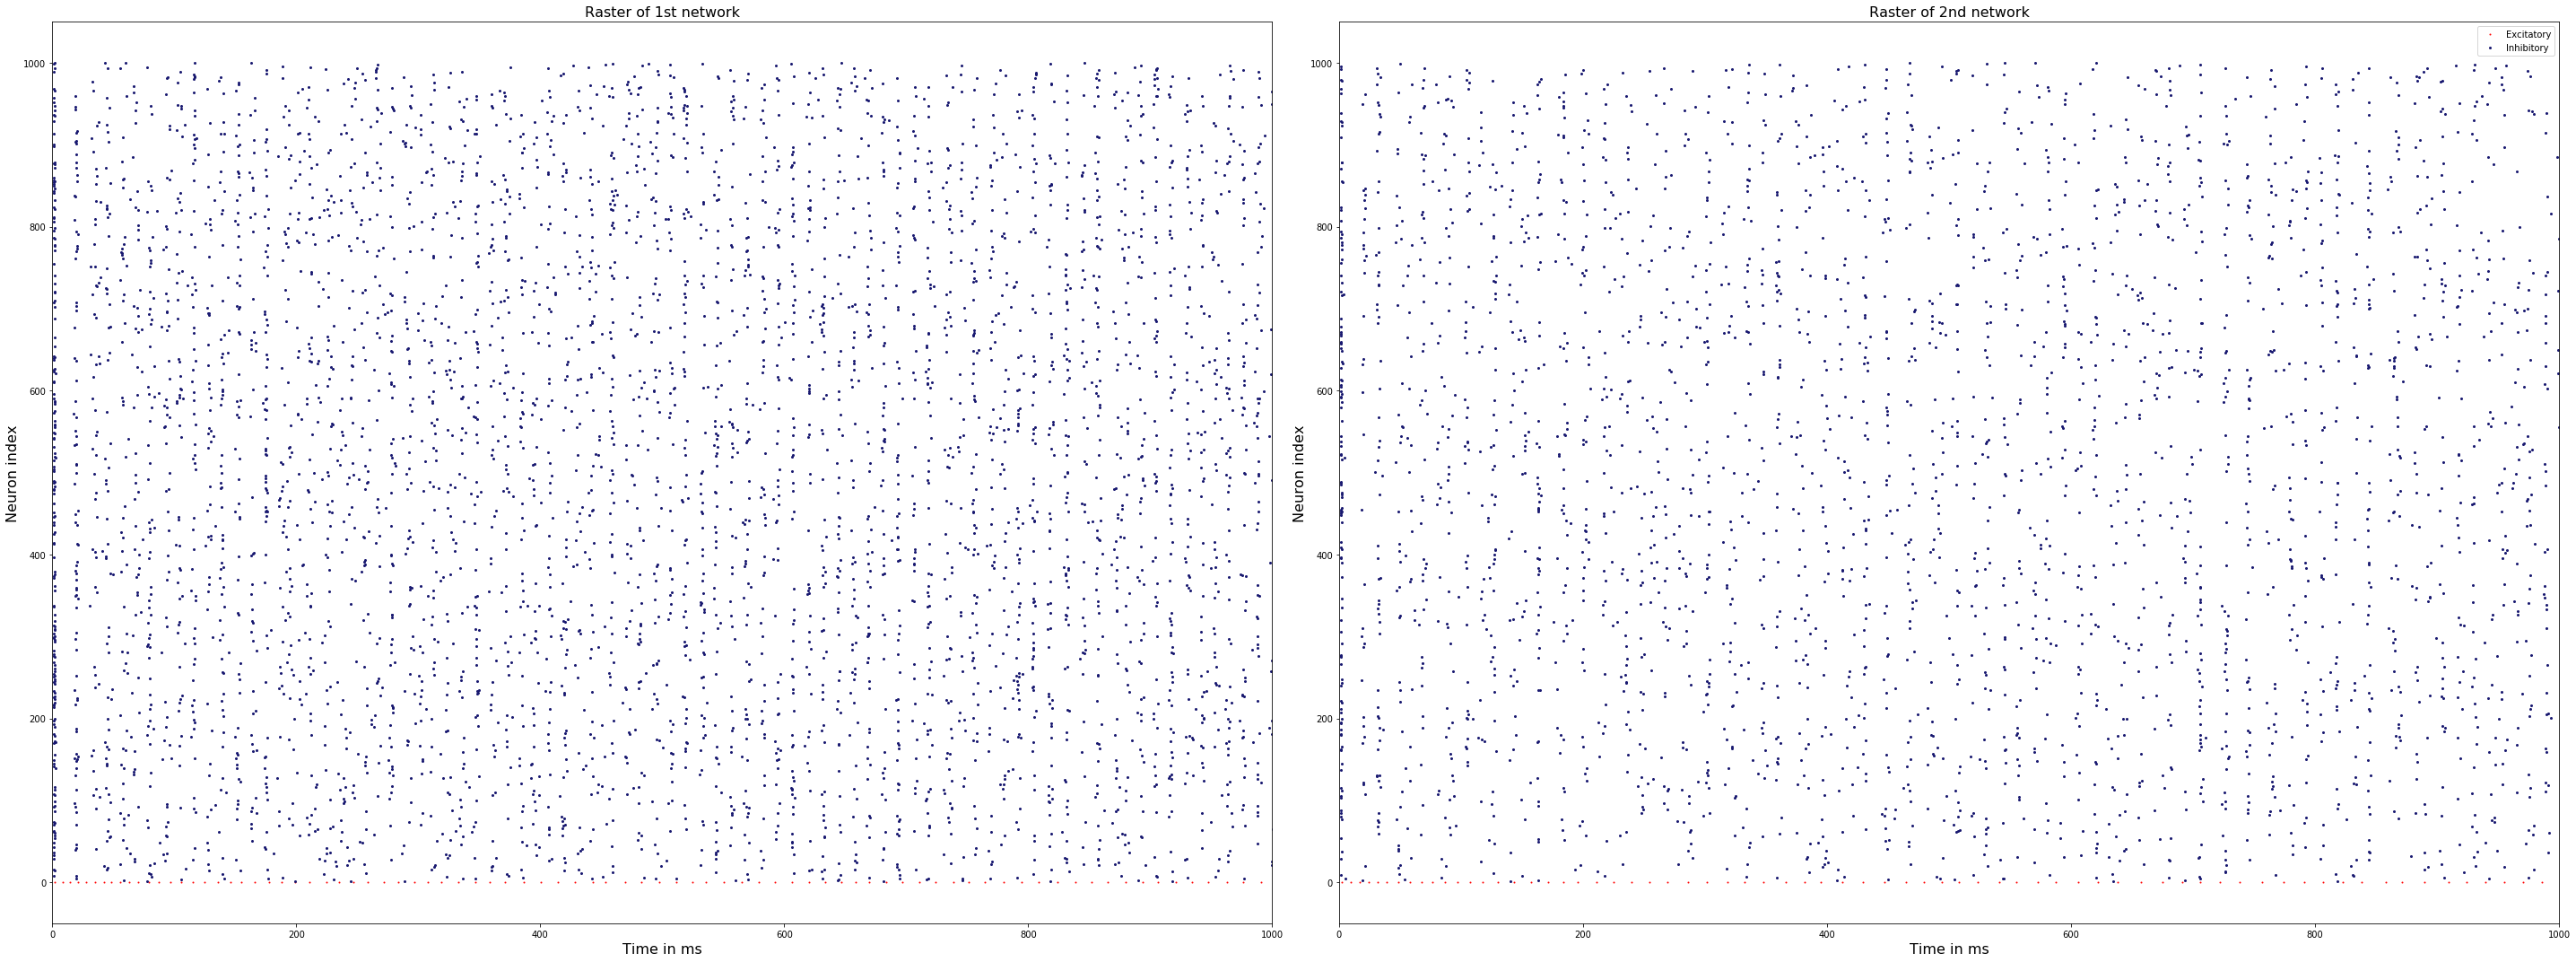

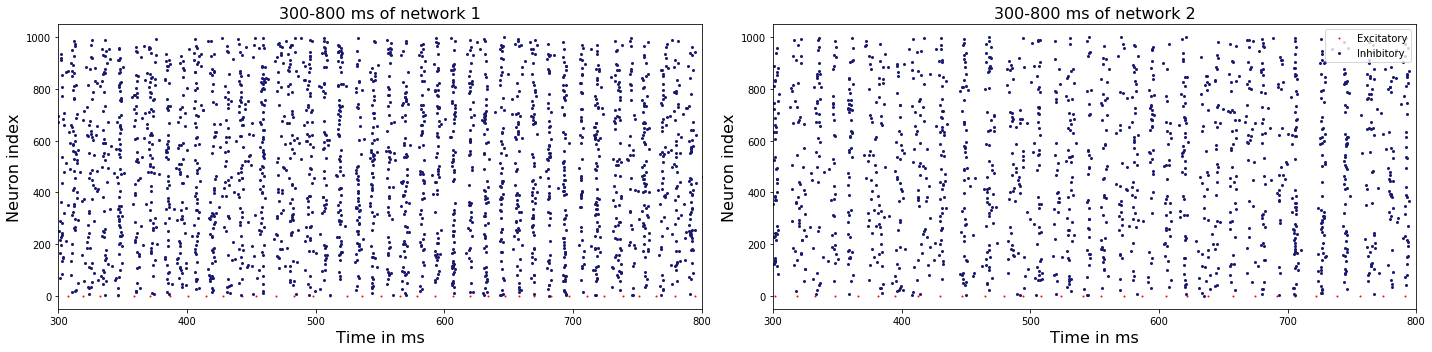

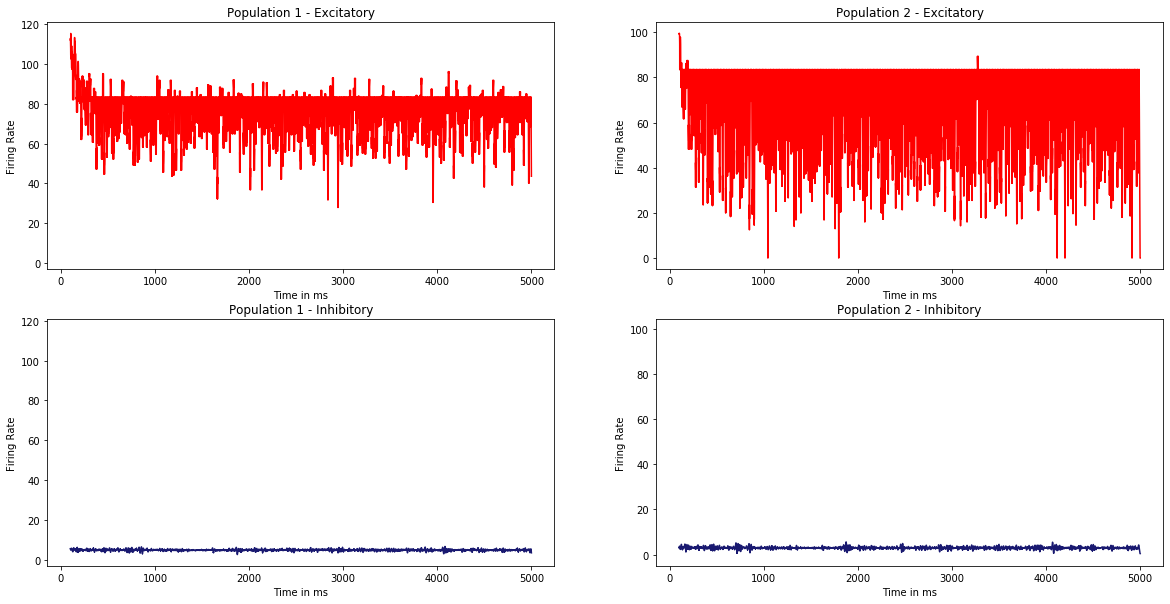

In [31]:
plots.plot_results(model, full_raster=True, psd_group="INH", excerpt_x_left=300, excerpt_x_right=800, raster_right=1000)

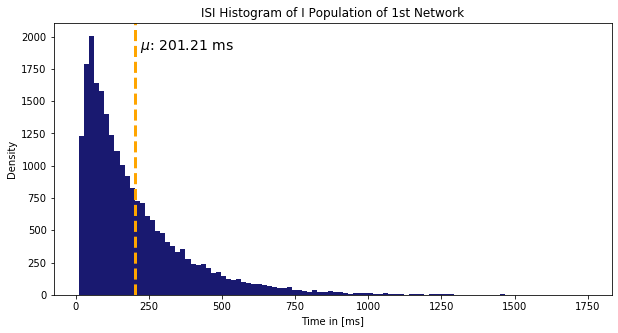

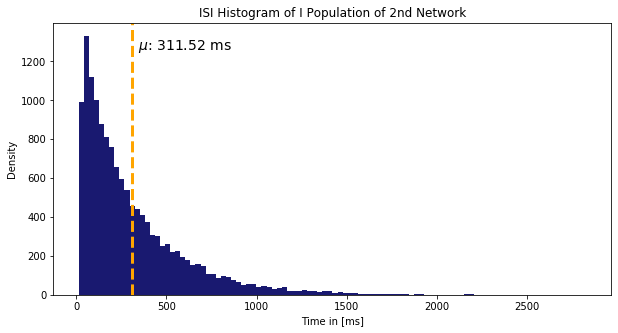

In [32]:
plots.isi_histograms(model, bins=100)

#### Spike Variability of I neurons explain synchronization

Only a fraction of neurons participate in each cycle, this allows the slower network 2 to speedend to the frequency of network 1. 

**How?** Once I cells fire in Net 1 inhbition is propagated to Net 2 surpressing a fraction of the I cells. Once inhibitory delay wears of, I cells in net 1 fire again together with the fraction of net 2 that has been surpressed.
However, the other fraction does not fire as they are now surpressed by inhibition.

The increased noise strength increases the membrane voltage heterogenity in both networks, so that the inhibition of I cells in net 1 is significantly more likely to surpress some of the neurons in net 2, while other neurons fire as inhibiton is not strong enough.

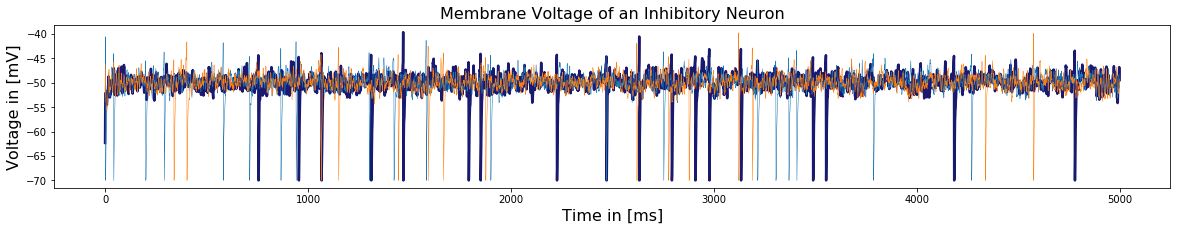

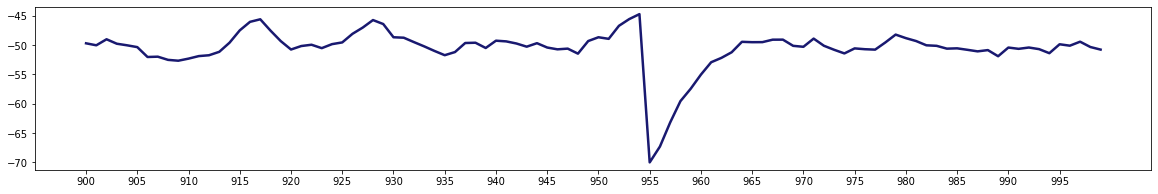

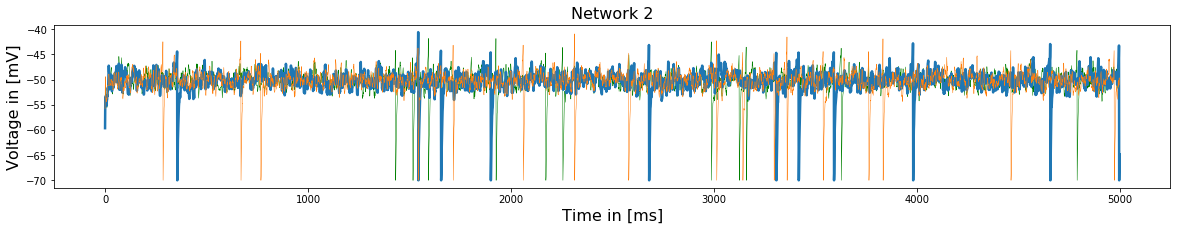

In [8]:
plots.membrane_potentials_sample(model)

-70.0 1312.0
36
964


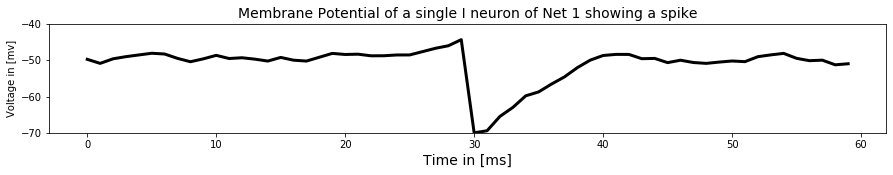

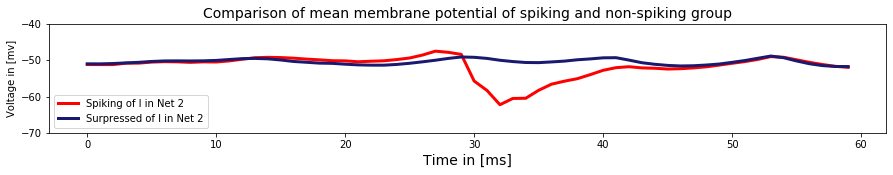

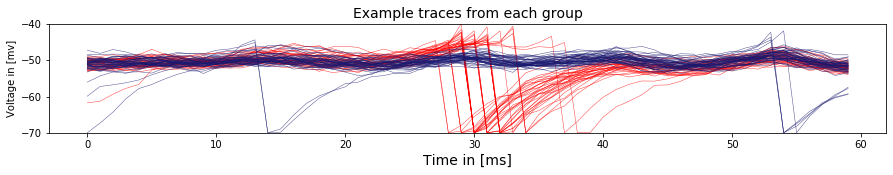

In [11]:
v = model["v_all_neurons_i1"]
v2 = model["v_all_neurons_i2"]
t = model["t_all_neurons_i1"]

# window = (940, 970)
w = (1300, 2000)
v_s, t_s = processing.get_first_spike(v, t, window=w)
print(v_s, t_s)

window = (int(t_s - 30), int(t_s + 30))

plots.spike_variability_analysis(v, v2, window=window, t_s=t_s, t_width=(6, 8))

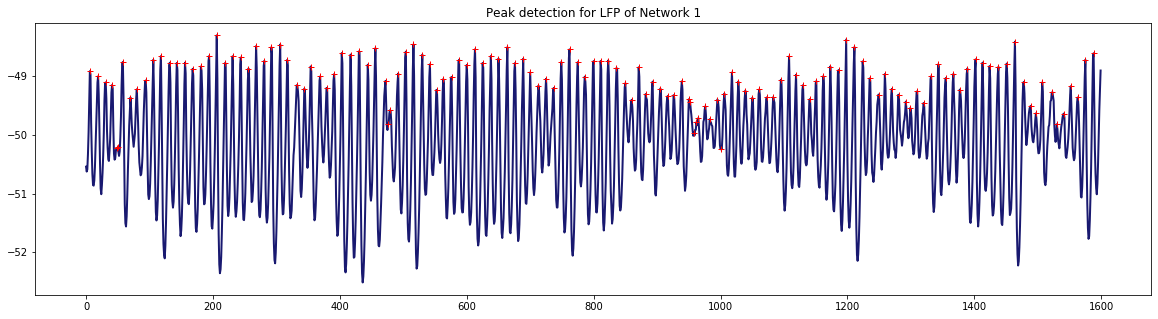

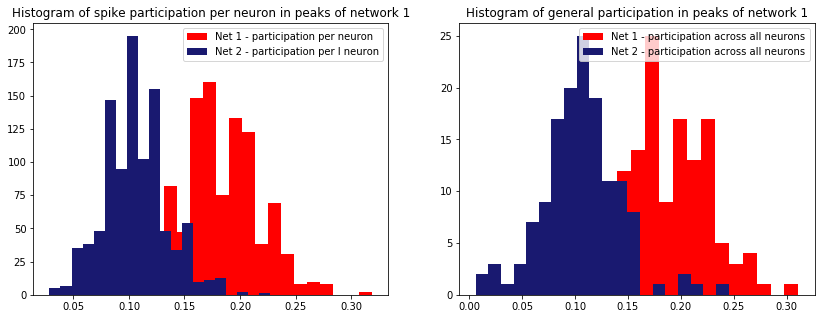

In [33]:
plots.spike_participation_histograms(model)

# Exploration

## Exploration over Noise Strength 1d

In [107]:
exp_params = {
    "poisson_variance": np.arange(0.5, 2.0, 0.1),
}

ov_params = dict(params)
ov_params.update({
    "runtime": 2000.0,
    "const_delay": 0.0,
    "poisson_p": 0.84,
})

ex = mopet.Exploration(
    runner.run_in_mopet, 
    explore_params=exp_params, 
    default_params=ov_params,
    hdf_filename=constants.MODELS_PATH + "/ING_synch_noise_1d.h5",
    exploration_name="exp_6"
)

In [108]:
ex.run()

2020-07-22 11:18:46,101	INFO resource_spec.py:212 -- Starting Ray with 11.18 GiB memory available for workers and up to 5.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-22 11:18:46,335	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-07-22 11:18:46,496	INFO services.py:1165 -- View the Ray dashboard at localhost:8265
INFO:root:Starting 15 jobs.
100%|██████████| 15/15 [00:00<00:00, 833.29it/s]
INFO:root:Runs took 0.022222280502319336 s to submit.
  0%|          | 0/15 [00:00<?, ?it/s]

(pid=7395) Starting simulation at t=0. s for a duration of 2. s
(pid=7387) Starting simulation at t=0. s for a duration of 2. s
(pid=7385) Starting simulation at t=0. s for a duration of 2. s
(pid=7396) Starting simulation at t=0. s for a duration of 2. s
(pid=7388) Starting simulation at t=0. s for a duration of 2. s
(pid=7393) Starting simulation at t=0. s for a duration of 2. s
(pid=7394) Starting simulation at t=0. s for a duration of 2. s
(pid=7395) 0.4486 s (22%) simulated in 10s, estimated 35s remaining.
(pid=7387) 0.4605 s (23%) simulated in 10s, estimated 33s remaining.
(pid=7385) 0.46225 s (23%) simulated in 10s, estimated 33s remaining.
(pid=7396) 0.4553 s (22%) simulated in 10s, estimated 34s remaining.
(pid=7388) 0.45385 s (22%) simulated in 10s, estimated 34s remaining.
(pid=7393) 0.45055 s (22%) simulated in 10s, estimated 34s remaining.
(pid=7391) Starting simulation at t=0. s for a duration of 2. s
(pid=7392) Starting simulation at t=0. s for a duration of 2. s
(pid=73

 13%|█▎        | 2/15 [01:21<12:16, 56.65s/it]

(pid=7395) Starting simulation at t=0. s for a duration of 2. s
(pid=7385) Starting simulation at t=0. s for a duration of 2. s
(pid=7391) 1.8186 s (90%) simulated in 50s, estimated 5s remaining.
(pid=7392) 1.82255 s (91%) simulated in 50s, estimated 5s remaining.
(pid=7386) 1.88855 s (94%) simulated in 50s, estimated 3s remaining.
(pid=7390) 1.8238 s (91%) simulated in 50s, estimated 5s remaining.
(pid=7389) 1.8216 s (91%) simulated in 50s, estimated 5s remaining.
(pid=7391) 2. s (100%) simulated in 54s
(pid=7391) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=7392) 2. s (100%) simulated in 54s
(pid=7392) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=7386) 2. s (100%) simulated in 52s
(pid=7386) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=7390) 2. s (100%) simulated in 54s
(pid=7390) INFO       width adjusted from 10. ms to 

 40%|████      | 6/15 [01:37<02:18, 15.36s/it]

(pid=7387) Starting simulation at t=0. s for a duration of 2. s


 80%|████████  | 12/15 [01:39<00:06,  2.03s/it]

(pid=7395) 1.01845 s (50%) simulated in 20s, estimated 19s remaining.
(pid=7385) 1.0365 s (51%) simulated in 20s, estimated 19s remaining.
(pid=7387) 0.72605 s (36%) simulated in 10s, estimated 18s remaining.
(pid=7395) 1.88045 s (94%) simulated in 30s, estimated 2s remaining.
(pid=7385) 1.90735 s (95%) simulated in 30s, estimated 1s remaining.
(pid=7395) 2. s (100%) simulated in 31s
(pid=7385) 2. s (100%) simulated in 30s
(pid=7387) 1.64825 s (82%) simulated in 20s, estimated 4s remaining.
(pid=7387) 2. s (100%) simulated in 23s


100%|██████████| 15/15 [02:03<00:00,  8.25s/it]
INFO:root:Runs and storage took 123.74396085739136 s to complete.


In [109]:
ex.load_results(all=True)

INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise_1d.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exp_6``
100%|██████████| 15/15 [00:01<00:00, 12.01it/s]
INFO:root:Creating new results DataFrame
INFO:root:Aggregating scalar results ...
100%|██████████| 15/15 [00:01<00:00, 10.78it/s]
INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise_1d.h5 closed.


### Results

{'J_etoe': 0.0,
 'J_etoi': 0.0,
 'J_itoe': 0.0,
 'J_itoi': 0.4,
 'J_ppee': 0.0,
 'J_ppei': 0.0,
 'J_ppii': 0.15,
 'N_e': 1,
 'N_i': 1000,
 'N_pop': 2,
 'const_delay': 0.0,
 'model_EI': False,
 'net_record_spikes': 200,
 'ou_enabled': [False, False],
 'p_etoe': 0,
 'p_etoi': 0.0,
 'p_itoe': 0.0,
 'p_itoi': 1.0,
 'p_ppee': 0.0,
 'p_ppei': 0.0,
 'p_ppii': 1.0,
 'poisson_I_enabled': True,
 'poisson_I_ratio': 1.0,
 'poisson_enabled': [True, True],
 'poisson_mean_input': 300,
 'poisson_p': 0.84,
 'poisson_size': 800,
 'poisson_variance': 0.5,
 'runtime': 2000.0,
 'syn_net_exc': False,
 'syn_net_inh': True,
 'tau_GABA': 20.0}


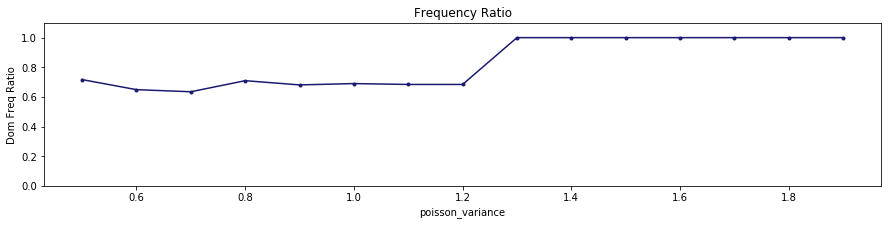

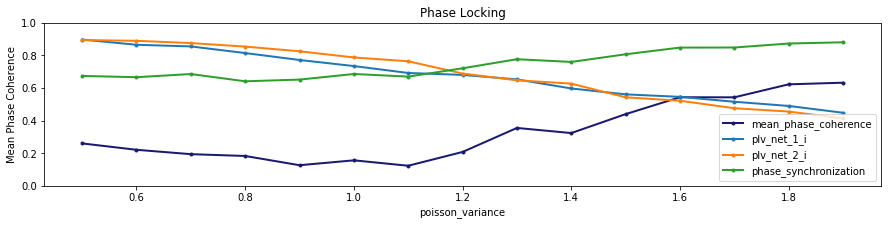

In [110]:
import pprint

plots.plot_exploration(ex, vmin_ratio=None, vmin_phase=None, vmax_phase=None)
pprint.pprint(ex.default_params)

INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise_1d.h5 opened for reading.


Global Order Parameter value of: 0.880578264766467
Mean Phase Coherence 0.6327996023545852
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.45933362391218235
Within Synchronization of Network 2 0.42197225204978517


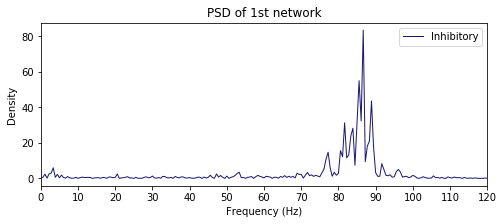

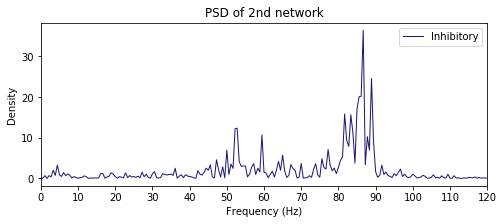

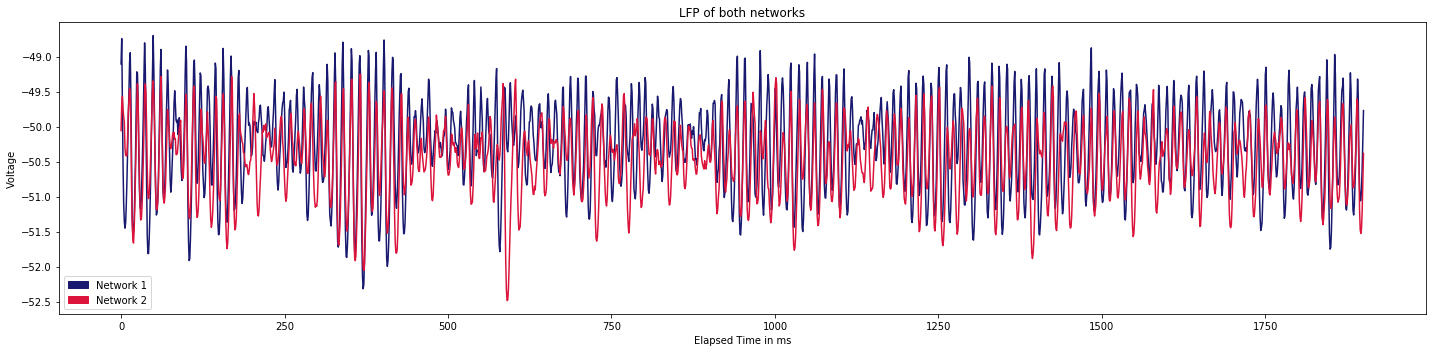

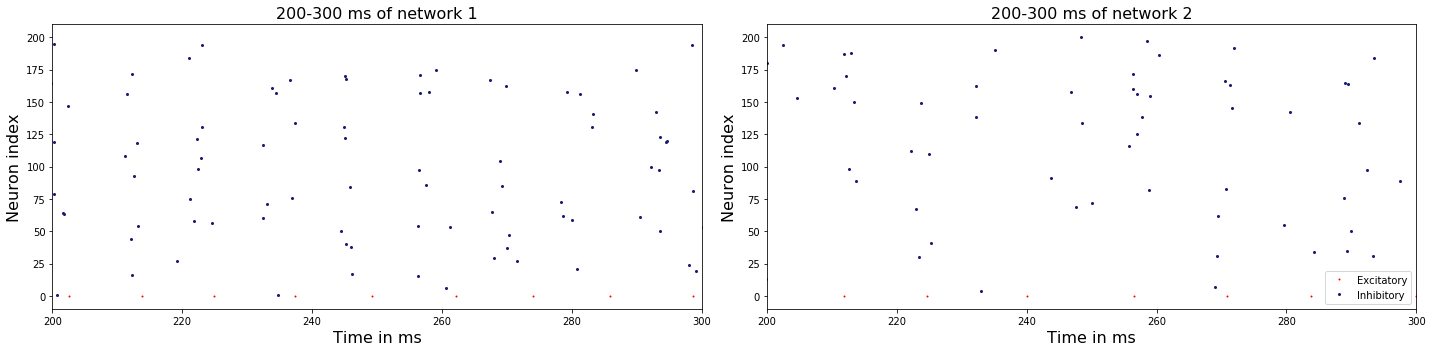

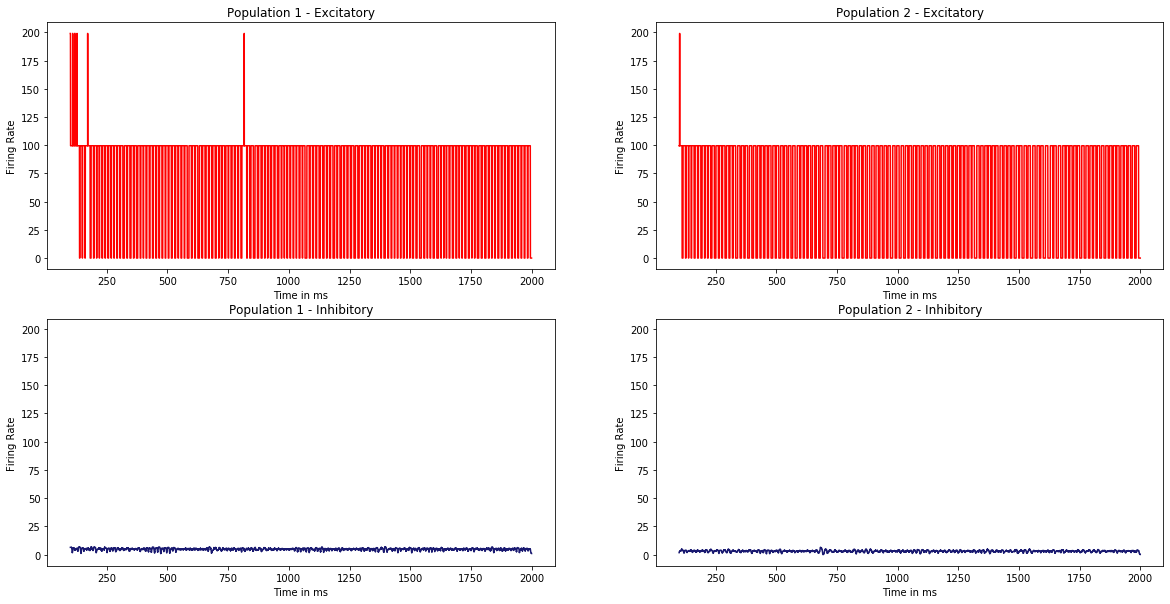

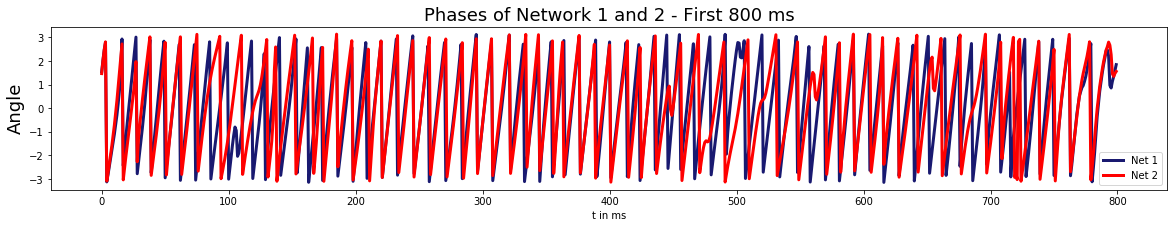

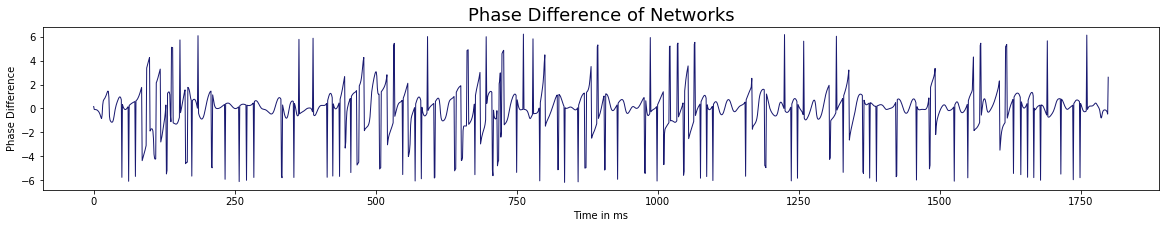

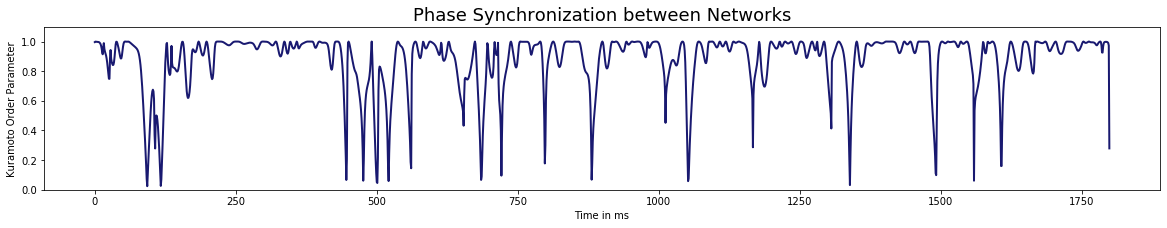

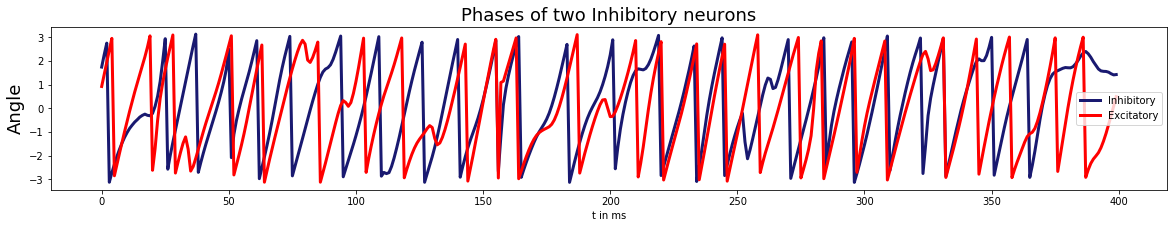

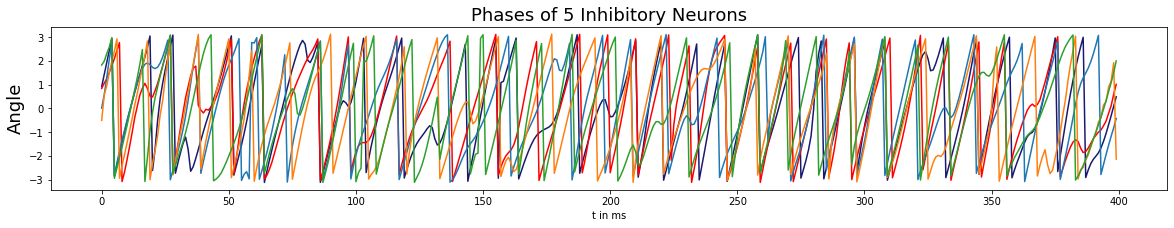

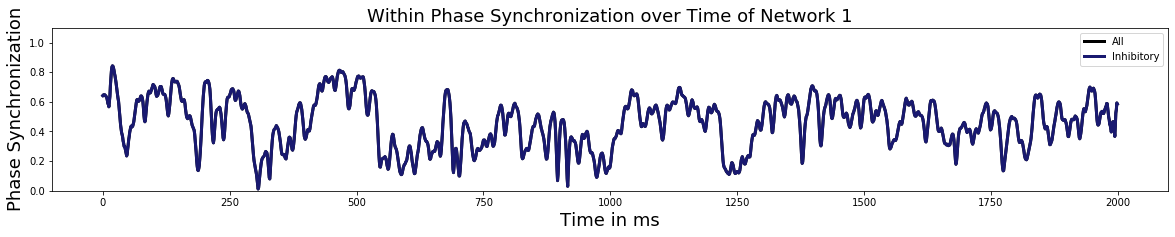

In [111]:
plots.plot_results(ex.get_run(14), psd_group="INH")

In [7]:
ex.params

{0: {'poisson_variance': 0.5},
 1: {'poisson_variance': 1.5},
 10: {'poisson_variance': 10.5},
 11: {'poisson_variance': 11.5},
 12: {'poisson_variance': 12.5},
 13: {'poisson_variance': 13.5},
 14: {'poisson_variance': 14.5},
 2: {'poisson_variance': 2.5},
 3: {'poisson_variance': 3.5},
 4: {'poisson_variance': 4.5},
 5: {'poisson_variance': 5.5},
 6: {'poisson_variance': 6.5},
 7: {'poisson_variance': 7.5},
 8: {'poisson_variance': 8.5},
 9: {'poisson_variance': 9.5}}

Global Order Parameter value of: 0.6701596759795648
Mean Phase Coherence 0.12356346574053309
Computing within synchronization for network 1 and 2
Within Synchronization of Network 1 0.6929046283195431
Within Synchronization of Network 2 0.7694923329836036


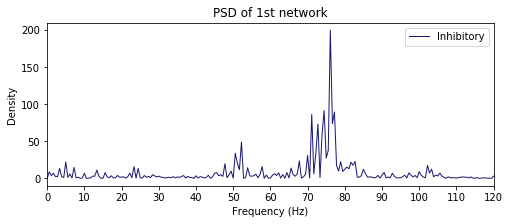

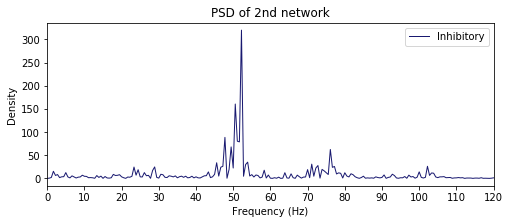

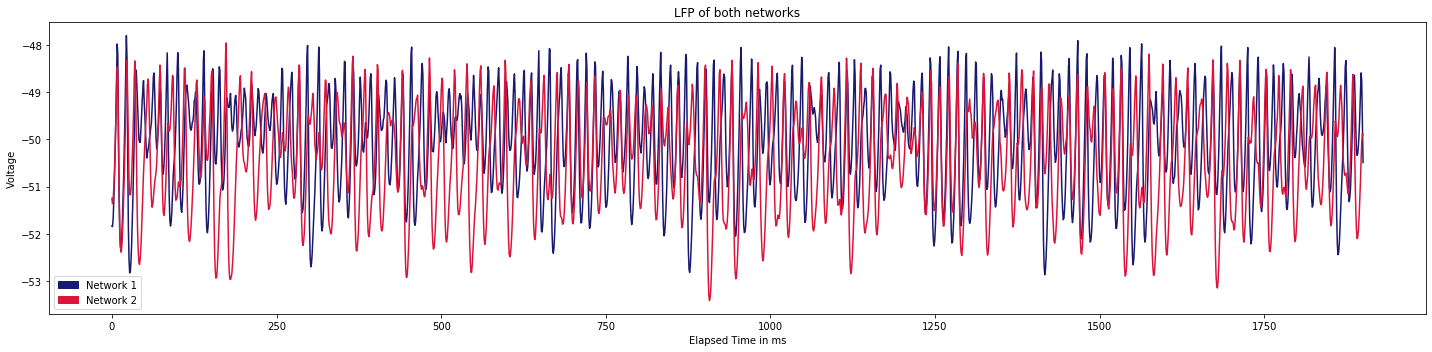

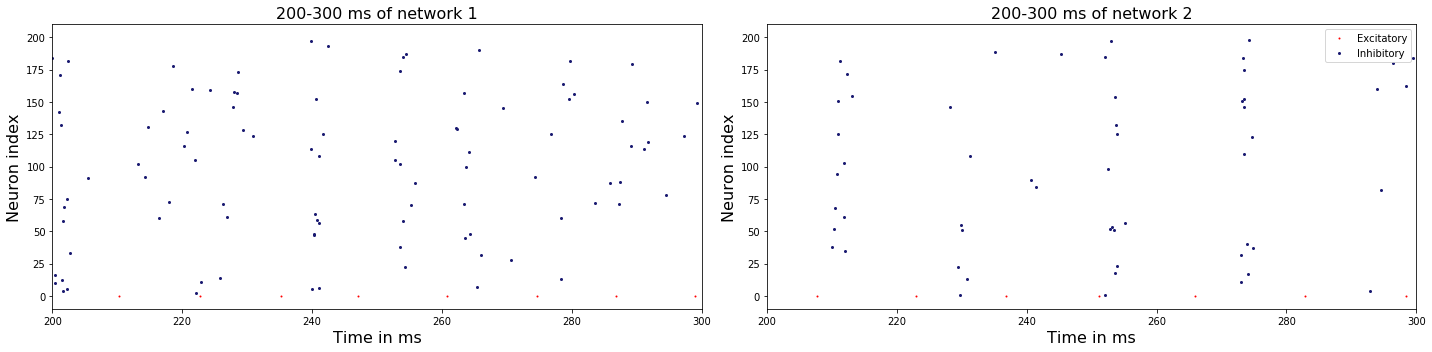

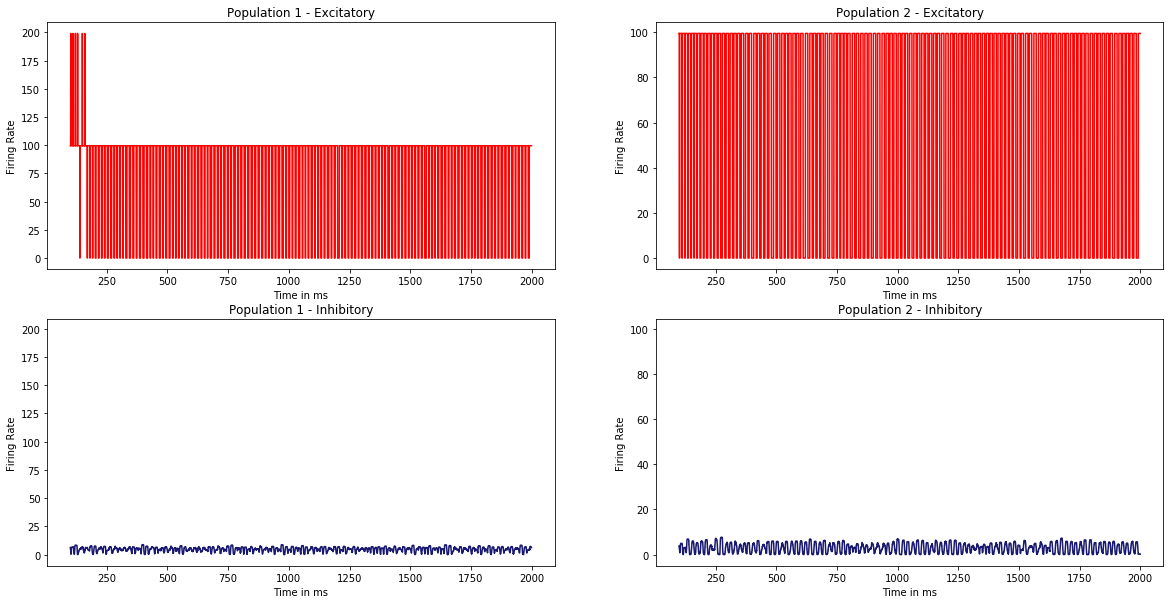

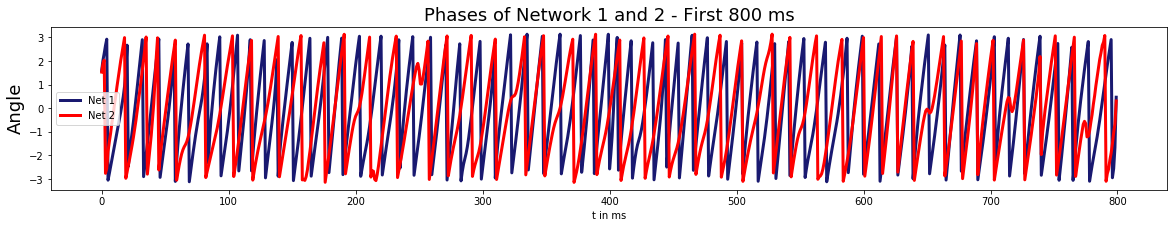

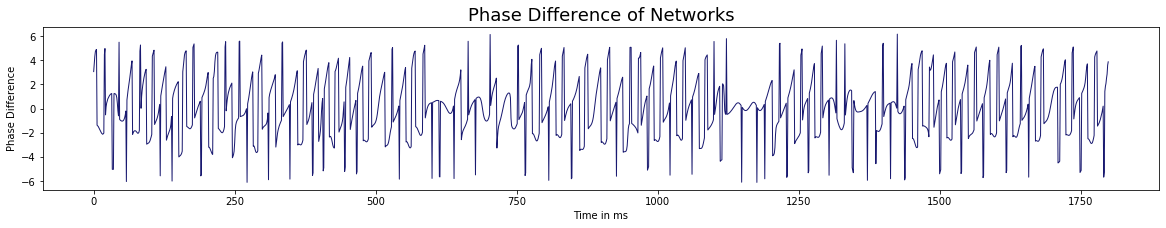

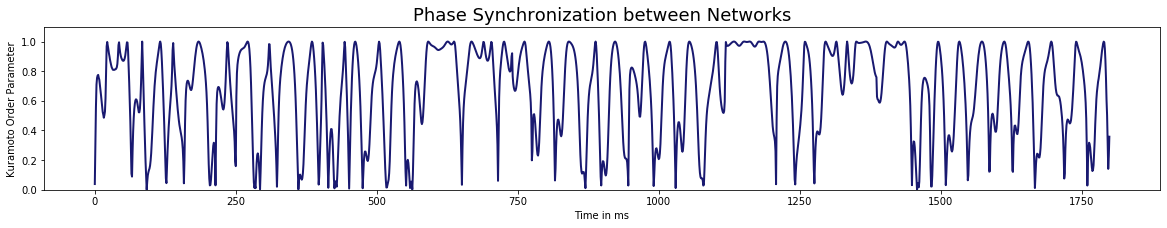

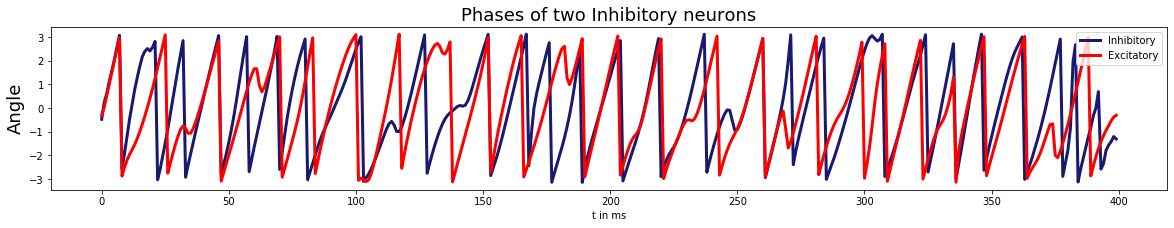

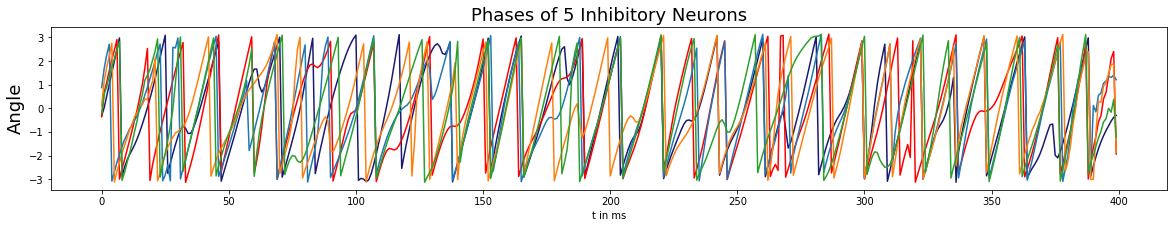

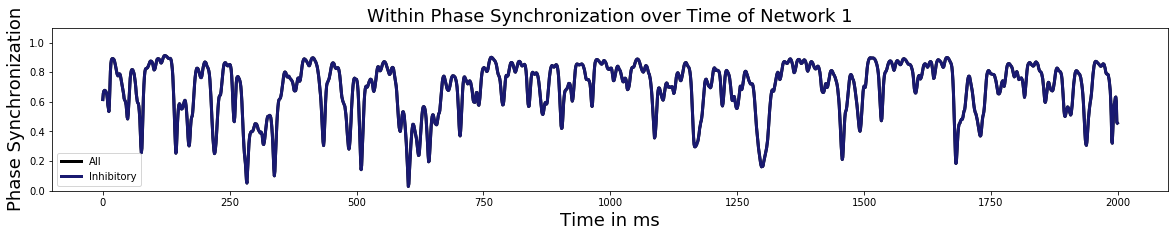

In [112]:
plots.plot_results(ex.get_run(6), psd_group="INH")

## Exploration over Noise Strength and Ratio (2d)

In [126]:
exp_params = {
    "poisson_variance": np.arange(0.5, 2.0, 0.1),
    "poisson_p": np.arange(0.7, 1.0, 0.05),
}

ov_params = dict(params)
ov_params.update({
    "runtime": 3000.0,
    "J_ppii": 0.15,
    "J_itoi": 0.4,
    "const_delay": 0.0
})

ex = mopet.Exploration(
    runner.run_in_mopet, 
    explore_params=exp_params, 
    default_params=ov_params,
    hdf_filename=constants.MODELS_PATH + "/ING_synch_noise.h5",
    exploration_name="exp_1"
)

In [127]:
ex.run()

2020-07-22 11:48:56,432	INFO resource_spec.py:212 -- Starting Ray with 10.25 GiB memory available for workers and up to 5.13 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-22 11:48:56,674	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-07-22 11:48:56,834	INFO services.py:1165 -- View the Ray dashboard at localhost:8265
INFO:root:Starting 105 jobs.
100%|██████████| 105/105 [00:00<00:00, 507.23it/s]
INFO:root:Runs took 0.21068596839904785 s to submit.
  0%|          | 0/105 [00:00<?, ?it/s]

(pid=8095) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) Starting simulation at t=0. s for a duration of 3. s
(pid=8095) 0.40115 s (13%) simulated in 10s, estimated 1m 5s remaining.
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8098) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8106) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) 0.3567 s (11%) simulated in 10s, estimated 1m 14s remaining.
(pid=8095) 0.7955 s (26%) simulated in 20s, estimated 55s remaining.
(pid=8100) 0.42075 

  1%|          | 1/105 [01:57<3:23:13, 117.25s/it]

(pid=8103) 3. s (100%) simulated in 1m 22s
(pid=8103) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=8099) 3. s (100%) simulated in 1m 24s
(pid=8099) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=8096) 3. s (100%) simulated in 1m 26s
(pid=8096) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]


 11%|█▏        | 12/105 [02:16<04:24,  2.84s/it]  

(pid=8104) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) 0.35515 s (11%) simulated in 10s, estimated 1m 14s remaining.
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) 0.3188 s (10%) simulated in 10s, estimated 1m 24s remaining.
(pid=8101) 0.322 s (10%) simulated in 10s, estimated 1m 23s remaining.
(pid=8097) 0.3364 s (11%) simulated in 10s, estimated 1m 19s remaining.
(pid=8102) 0.3245 s (10%) simulated in 10s, estimated 1m 22s remaining.


 13%|█▎        | 14/105 [04:03<36:26, 24.02s/it]

(pid=8108) 2.98265 s (99%) simulated in 1m 20s, estimated < 1s remaining.
(pid=8104) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) 2.97465 s (99%) simulated in 1m 20s, estimated 1s remaining.
(pid=8108) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=8108) 3. s (100%) simulated in 1m 20s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]
(pid=8114) 3. s (100%) simulated in 1m 20s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) Starting simulation at t=0. s for a duration of 3. s


 16%|█▌        | 17/105 [04:19<15:39, 10.67s/it]

(pid=8104) 304.05 ms (10%) simulated in 10s, estimated 1m 29s remaining.


 18%|█▊        | 19/105 [04:20<07:52,  5.49s/it]

(pid=8100) 0.31795 s (10%) simulated in 10s, estimated 1m 24s remaining.
(pid=8097) 315.2 ms (10%) simulated in 10s, estimated 1m 25s remaining.


 19%|█▉        | 20/105 [04:21<05:40,  4.01s/it]

(pid=8101) 307.15 ms (10%) simulated in 10s, estimated 1m 28s remaining.


 23%|██▎       | 24/105 [04:23<01:50,  1.37s/it]

(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) 257.55 ms (8%) simulated in 10s, estimated 1m 46s remaining.
(pid=8096) 248.75 ms (8%) simulated in 10s, estimated 1m 51s remaining.
(pid=8105) 251.1 ms (8%) simulated in 10s, estimated 1m 49s remaining.
(pid=8102) 250. ms (8%) simulated in 10s, estimated 1m 50s remaining.
(pid=8104) 0.55355 s (18%) simulated in 20s, estimated 1m 28s remaining.
(pid=8100) 0.58155 s (19%) simulated in 20s, estimated 1m 23s remaining.
(pid=8097) 0.58775 s (19%) simulated in 20s, estimated 1m 22s remaining.
(pid=8101) 0.58215 s (19%) simulated in 20s, estimated 1m 23s remaining.
(pid=8099) 307.95 ms (10%) simulated in 10s, estimated 1m 27s remaining.
(pid=8113) 309.55 ms (10%) simulated in 10s, estimated 1m 27s remaining.
(pid=8103) 0.58075 s (19%) simulated in 20s, estimated 1m 23s remaining.
(pid=8096) 0.56455 s (18%) simulated in 20s, estimated 1m 26s remaining.
(pi

 24%|██▍       | 25/105 [05:44<33:47, 25.34s/it]

(pid=8099) 2.8781 s (95%) simulated in 1m 20s, estimated 3s remaining.
(pid=8096) 3. s (100%) simulated in 1m 27s


 25%|██▍       | 26/105 [05:44<23:28, 17.83s/it]

(pid=8102) 3. s (100%) simulated in 1m 26s
(pid=8113) 2.8661 s (95%) simulated in 1m 20s, estimated 4s remaining.


 27%|██▋       | 28/105 [05:45<11:27,  8.93s/it]

(pid=8099) 3. s (100%) simulated in 1m 23s
(pid=8113) 3. s (100%) simulated in 1m 23s


 28%|██▊       | 29/105 [05:49<09:30,  7.51s/it]

(pid=8108) 2.67405 s (89%) simulated in 1m 10s, estimated 9s remaining.
(pid=8114) 2.59775 s (86%) simulated in 1m 10s, estimated 11s remaining.


 32%|███▏      | 34/105 [05:55<02:25,  2.04s/it]

(pid=8108) 3. s (100%) simulated in 1m 18s
(pid=8104) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) 2.94635 s (98%) simulated in 1m 20s, estimated 1s remaining.
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) 3. s (100%) simulated in 1m 21s


 33%|███▎      | 35/105 [06:08<06:06,  5.23s/it]

(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) 282.05 ms (9%) simulated in 10s, estimated 1m 36s remaining.
(pid=8101) 283.15 ms (9%) simulated in 10s, estimated 1m 36s remaining.
(pid=8100) 284.4 ms (9%) simulated in 10s, estimated 1m 35s remaining.
(pid=8097) 279.65 ms (9%) simulated in 10s, estimated 1m 37s remaining.


 34%|███▍      | 36/105 [06:11<05:26,  4.73s/it]

(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) 266.8 ms (8%) simulated in 10s, estimated 1m 42s remaining.
(pid=8105) 264.25 ms (8%) simulated in 10s, estimated 1m 44s remaining.
(pid=8104) 0.5461 s (18%) simulated in 20s, estimated 1m 30s remaining.
(pid=8101) 0.5488 s (18%) simulated in 20s, estimated 1m 29s remaining.
(pid=8100) 0.5524 s (18%) simulated in 20s, estimated 1m 29s remaining.
(pid=8097) 0.5484 s (18%) simulated in 20s, estimated 1m 29s remaining.
(pid=8102) 270.2 ms (9%) simulated in 10s, estimated 1m 41s remaining.
(pid=8096) 271.3 ms (9%) simulated in 10s, estimated 1m 41s remaining.
(pid=8114) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) 282.85 ms (9%) simulated in 10s, estimated 1m 36s remaining.
(pid=8113) 285.3 ms (9%) simulated 

 36%|███▌      | 38/105 [07:35<22:14, 19.92s/it]

(pid=8114) 2.5922 s (86%) simulated in 1m 10s, estimated 11s remaining.


 38%|███▊      | 40/105 [07:36<10:45,  9.93s/it]

(pid=8099) 2.89925 s (96%) simulated in 1m 20s, estimated 3s remaining.
(pid=8096) 3. s (100%) simulated in 1m 24s
(pid=8102) 3. s (100%) simulated in 1m 25s
(pid=8113) 2.8736 s (95%) simulated in 1m 20s, estimated 4s remaining.
(pid=8099) 3. s (100%) simulated in 1m 22s


 39%|███▉      | 41/105 [07:40<08:51,  8.30s/it]

(pid=8108) 2.62115 s (87%) simulated in 1m 10s, estimated 10s remaining.
(pid=8113) 3. s (100%) simulated in 1m 23s


 43%|████▎     | 45/105 [07:44<02:51,  2.86s/it]

(pid=8114) 2.996 s (99%) simulated in 1m 20s, estimated < 1s remaining.
(pid=8114) 3. s (100%) simulated in 1m 20s


 44%|████▍     | 46/105 [07:46<02:33,  2.61s/it]

(pid=8108) 3. s (100%) simulated in 1m 18s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) Starting simulation at t=0. s for a duration of 3. s


 46%|████▌     | 48/105 [07:56<03:14,  3.41s/it]

(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) 0.31985 s (10%) simulated in 10s, estimated 1m 24s remaining.
(pid=8101) 0.31735 s (10%) simulated in 10s, estimated 1m 25s remaining.
(pid=8097) 0.3185 s (10%) simulated in 10s, estimated 1m 24s remaining.
(pid=8104) 304.9 ms (10%) simulated in 10s, estimated 1m 28s remaining.
(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) Starting simulation at t=0. s for a duration of 3. s
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) 270.85 ms (9%) simulated in 10s, estimated 1m 41s remaining.
(pid=8096) 268. ms (8%) simulated in 10s, estimated 1m 42s remaining.
(pid=8105) 270.5 ms (9%) simulated in 10s, estimated 1m 41s remaining.
(pid=8103) 271. ms (9%) simulated in 10s, estimat

 50%|████▉     | 52/105 [09:29<09:14, 10.47s/it]

(pid=8108) 2.5445 s (84%) simulated in 1m 10s, estimated 13s remaining.
(pid=8099) 3. s (100%) simulated in 1m 26s
(pid=8114) 3. s (100%) simulated in 1m 25s
(pid=8113) 3. s (100%) simulated in 1m 25s


 56%|█████▌    | 59/105 [09:38<01:20,  1.74s/it]

(pid=8108) 2.96075 s (98%) simulated in 1m 20s, estimated 1s remaining.
(pid=8108) 3. s (100%) simulated in 1m 20s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) Starting simulation at t=0. s for a duration of 3. s


 57%|█████▋    | 60/105 [09:48<03:01,  4.04s/it]

(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) 0.33205 s (11%) simulated in 10s, estimated 1m 20s remaining.
(pid=8097) 0.3335 s (11%) simulated in 10s, estimated 1m 20s remaining.
(pid=8101) 0.32965 s (10%) simulated in 10s, estimated 1m 21s remaining.
(pid=8104) 0.33185 s (11%) simulated in 10s, estimated 1m 20s remaining.
(pid=8114) Starting simulation at t=0. s for a duration of 3. s
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) 306.75 ms (10%) simulated in 10s, estimated 1m 28s remaining.
(pid=8096) 290.2 ms (9%) simulated in 10s, estimated 1m 33s remaining.
(pid=8105) 290.5 ms (9%) simulated in 10s, estimated 1m 33s remaining.
(pid=8102) 291.25 ms (9%) simulated in 10s, es

 58%|█████▊    | 61/105 [11:19<22:14, 30.32s/it]

(pid=8108) 2.53455 s (84%) simulated in 1m 10s, estimated 13s remaining.


 61%|██████    | 64/105 [11:21<07:22, 10.78s/it]

(pid=8113) 3. s (100%) simulated in 1m 25s
(pid=8114) 3. s (100%) simulated in 1m 27s


 68%|██████▊   | 71/105 [11:30<01:03,  1.86s/it]

(pid=8108) 2.9674 s (98%) simulated in 1m 20s, estimated 1s remaining.
(pid=8108) 3. s (100%) simulated in 1m 20s
(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8104) Starting simulation at t=0. s for a duration of 3. s


 69%|██████▊   | 72/105 [11:36<01:45,  3.20s/it]

(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) 0.35495 s (11%) simulated in 10s, estimated 1m 15s remaining.
(pid=8104) 0.3542 s (11%) simulated in 10s, estimated 1m 15s remaining.
(pid=8101) 0.34955 s (11%) simulated in 10s, estimated 1m 16s remaining.
(pid=8097) 0.34845 s (11%) simulated in 10s, estimated 1m 16s remaining.
(pid=8100) 0.3486 s (11%) simulated in 10s, estimated 1m 16s remaining.
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) 0.32045 s (10%) simulated in 10s, estimated 1m 24s

 70%|██████▉   | 73/105 [13:19<17:36, 33.02s/it]

(pid=8114) 2.833 s (94%) simulated in 1m 30s, estimated 5s remaining.


 73%|███████▎  | 77/105 [13:22<03:58,  8.52s/it]

(pid=8114) 3. s (100%) simulated in 1m 37s
(pid=8113) 3. s (100%) simulated in 1m 38s
(pid=8108) 2.7461 s (91%) simulated in 1m 30s, estimated 8s remaining.


 77%|███████▋  | 81/105 [13:30<01:11,  2.97s/it]

(pid=8103) Starting simulation at t=0. s for a duration of 3. s
(pid=8108) 2.9736 s (99%) simulated in 1m 40s, estimated 1s remaining.


 78%|███████▊  | 82/105 [13:38<01:49,  4.74s/it]

(pid=8108) 3. s (100%) simulated in 1m 41s


 79%|███████▉  | 83/105 [13:39<01:16,  3.48s/it]

(pid=8103) 210.75 ms (7%) simulated in 10s, estimated 2m 12s remaining.
(pid=8096) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) Starting simulation at t=0. s for a duration of 3. s


 80%|████████  | 84/105 [13:49<01:55,  5.49s/it]

(pid=8104) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) 0.4752 s (15%) simulated in 20s, estimated 1m 46s remaining.
(pid=8114) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) 261.25 ms (8%) simulated in 10s, estimated 1m 45s remaining.
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8105) Starting simulation at t=0. s for a duration of 3. s
(pid=8102) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) 265.25 ms (8%) simulated in 10s, estimated 1m 43s remaining.
(pid=8100) 269.75 ms (8%) simulated in 10s, estimated 1m 41s remaining.
(pid=8097) 265.5 ms (8%) simulated in 10s, estimated 1m 43s remaining.
(pid=8099) 263.6 ms (8%) simulated in 10s, estimated 1m 44s remaining.
(pid=8104) 252.85 ms (8%) simulated in 10s, estimated 1m 49s remaining.
(pid=8103) 0.72335 s (24%) simulated in 30s, estimated 1m 34s remaining.
(pid=8114) 242.15 ms (8%) simulated in 10s, estimated 1m 54s remaining.
(pid=8096) 0.5011 s (16%) simulat

 85%|████████▍ | 89/105 [15:39<02:25,  9.09s/it]

(pid=8108) 3. s (100%) simulated in 1m 37s


 90%|████████▉ | 94/105 [15:44<00:22,  2.07s/it]

(pid=8103) Starting simulation at t=0. s for a duration of 3. s


 90%|█████████ | 95/105 [15:45<00:15,  1.55s/it]

(pid=8096) Starting simulation at t=0. s for a duration of 3. s


 91%|█████████▏| 96/105 [15:48<00:19,  2.17s/it]

(pid=8103) 0.3444 s (11%) simulated in 10s, estimated 1m 17s remaining.
(pid=8097) Starting simulation at t=0. s for a duration of 3. s
(pid=8099) Starting simulation at t=0. s for a duration of 3. s
(pid=8096) 0.3247 s (10%) simulated in 10s, estimated 1m 22s remaining.
(pid=8104) Starting simulation at t=0. s for a duration of 3. s
(pid=8101) Starting simulation at t=0. s for a duration of 3. s
(pid=8100) Starting simulation at t=0. s for a duration of 3. s
(pid=8114) Starting simulation at t=0. s for a duration of 3. s
(pid=8113) Starting simulation at t=0. s for a duration of 3. s
(pid=8103) 0.67785 s (22%) simulated in 20s, estimated 1m 9s remaining.
(pid=8097) 0.33315 s (11%) simulated in 10s, estimated 1m 20s remaining.
(pid=8099) 0.3316 s (11%) simulated in 10s, estimated 1m 20s remaining.
(pid=8096) 0.6529 s (21%) simulated in 20s, estimated 1m 12s remaining.
(pid=8104) 0.33005 s (11%) simulated in 10s, estimated 1m 21s remaining.
(pid=8101) 0.32575 s (10%) simulated in 10s, e

 92%|█████████▏| 97/105 [17:05<03:16, 24.62s/it]

(pid=8104) 2.87535 s (95%) simulated in 1m 10s, estimated 3s remaining.
(pid=8101) 2.8889 s (96%) simulated in 1m 10s, estimated 3s remaining.
(pid=8100) 2.92915 s (97%) simulated in 1m 10s, estimated 2s remaining.
(pid=8097) 3. s (100%) simulated in 1m 12s


 93%|█████████▎| 98/105 [17:08<02:05, 17.88s/it]

(pid=8099) 3. s (100%) simulated in 1m 12s
(pid=8100) 3. s (100%) simulated in 1m 11s
(pid=8104) 3. s (100%) simulated in 1m 12s
(pid=8101) 3. s (100%) simulated in 1m 12s
(pid=8114) 2.9732 s (99%) simulated in 1m 10s, estimated 1s remaining.
(pid=8113) 2.97565 s (99%) simulated in 1m 10s, estimated 1s remaining.
(pid=8114) 3. s (100%) simulated in 1m 10s
(pid=8113) 3. s (100%) simulated in 1m 10s


100%|██████████| 105/105 [17:17<00:00,  9.88s/it]
INFO:root:Runs and storage took 1037.2010140419006 s to complete.


In [128]:
ex.load_results(all=True)

INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exp_1``
100%|██████████| 105/105 [00:13<00:00,  8.02it/s]
INFO:root:Creating new results DataFrame
INFO:root:Aggregating scalar results ...
100%|██████████| 105/105 [00:11<00:00,  9.27it/s]
INFO:root:/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ING_synch_noise.h5 closed.


### Results

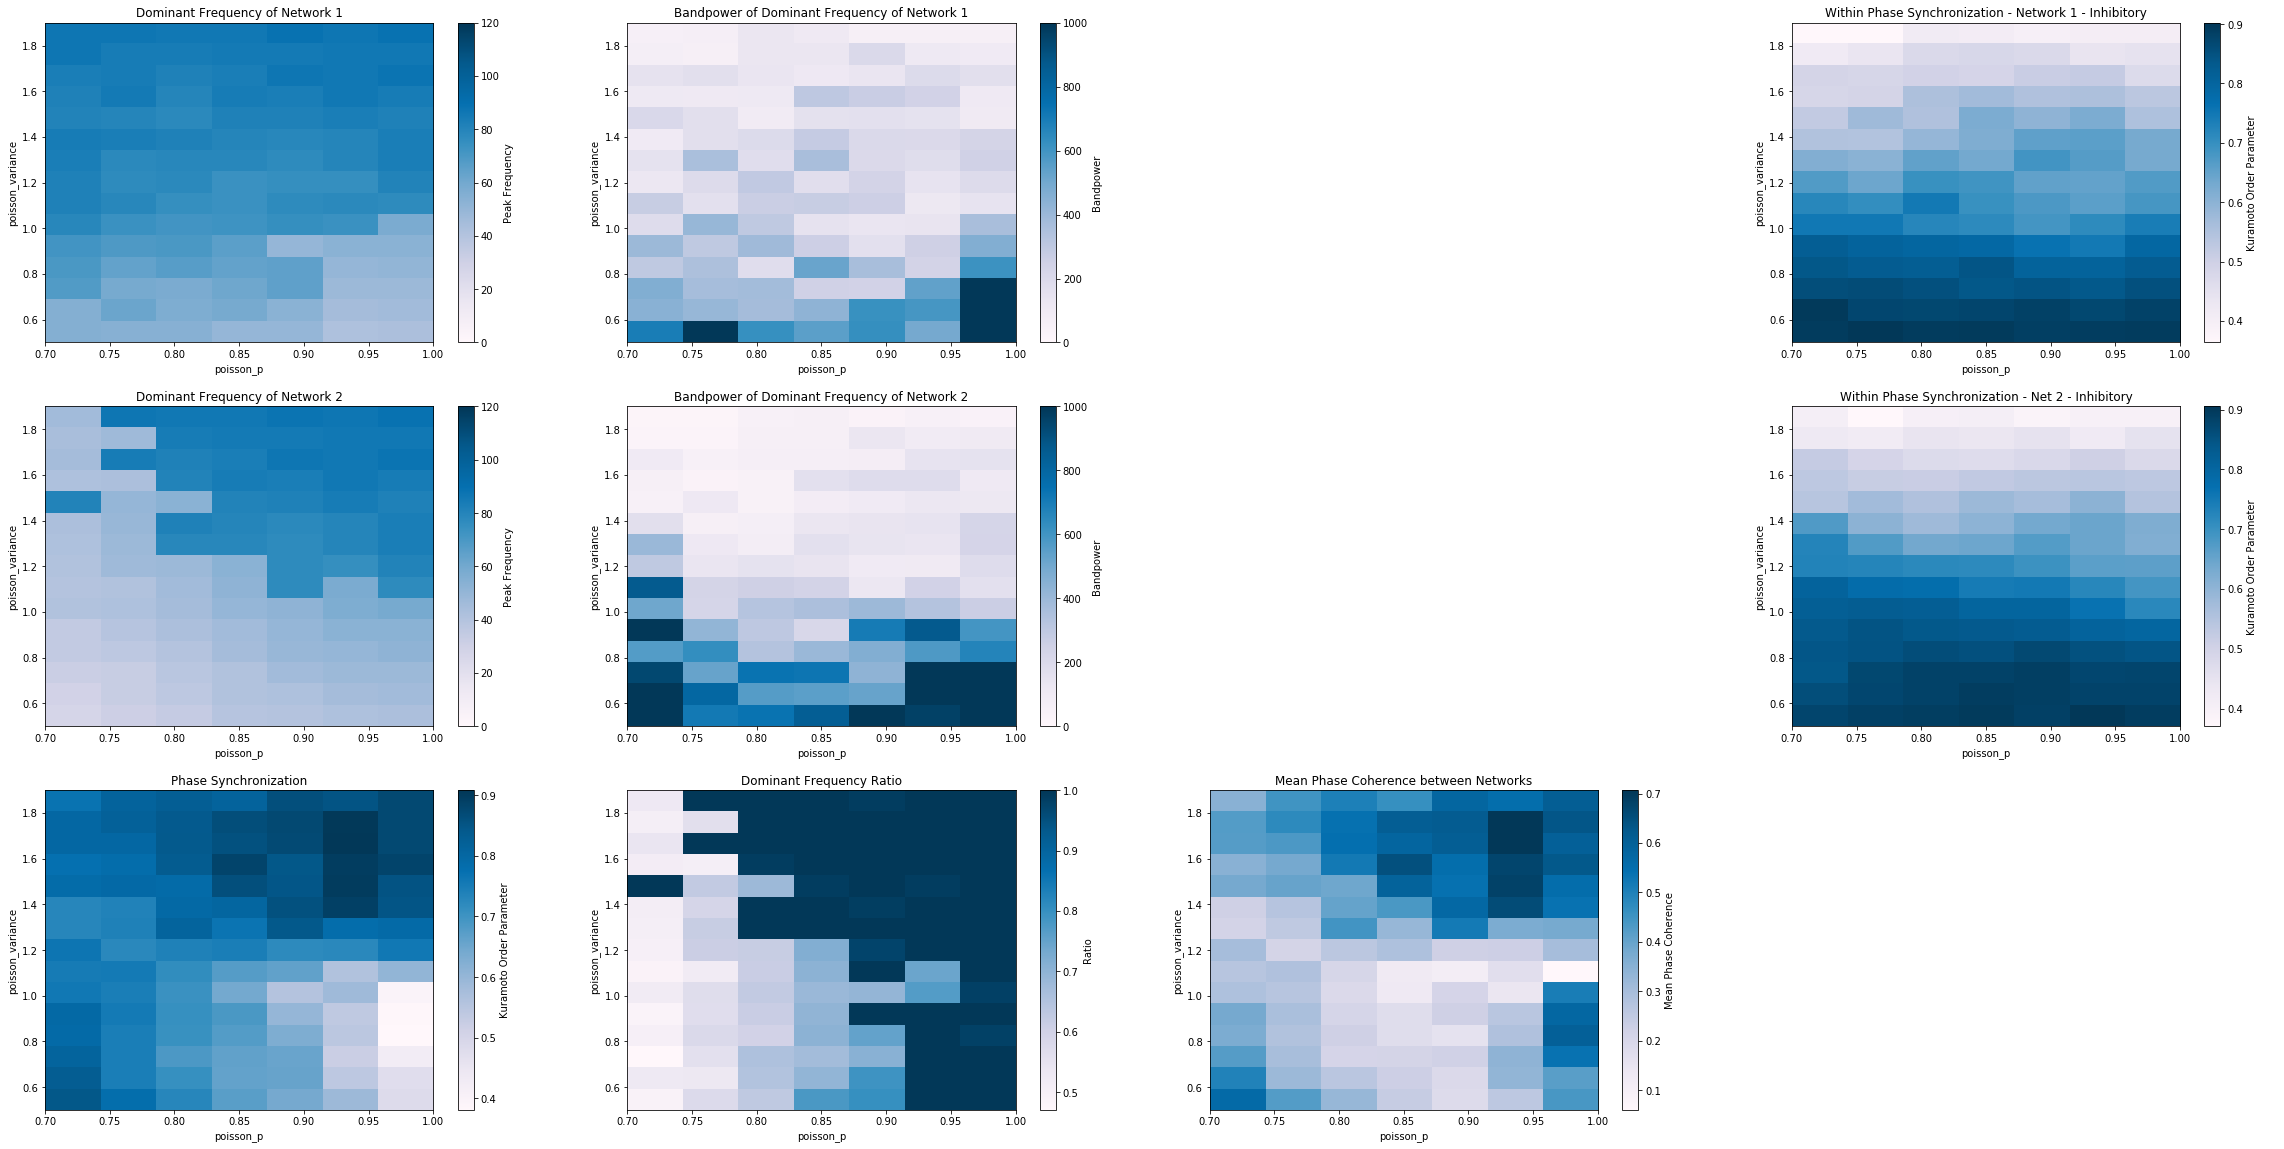

In [129]:
plots.plot_exploration(ex, vmin_ratio=None, vmin_phase=None, vmax_phase=None)